## Imports

In [40]:
import argparse
import os
import time
import sys
import random
import gc
import json
import pickle
from collections import Counter
from joblib import Parallel, delayed

import mat73
import concurrent.futures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mne
import nibabel as nib
import scipy
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

manualSeed = 111
SEED = manualSeed

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()


def reset_seed(seed=manualSeed):
    torch.manual_seed(seed)
    np.random.seed(seed)


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

DATA_PATH = '/data/kazachkovda/realWorldTableTennis'
SUB_ID = '09'

## EDA

Your dataset is organized as follows for each subject (e.g., `sub-01`):

- **`anat` Folder**:
  - `sub-01_T1w.nii`: De-identified T1-weighted anatomical MRI scan in NIfTI format.

- **`eeg` Folder**:
  - `sub-01_task-TableTennis_eeg.set`: EEGLAB dataset file containing EEG data.
  - `sub-01_task-TableTennis_eeg.fdt`: EEGLAB binary data file associated with the `.set` file.
  - `sub-01_task-TableTennis_channels.tsv`: Tab-separated file with channel information.
  - `sub-01_task-TableTennis_coordsystem.json`: JSON file describing the coordinate system.
  - `sub-01_task-TableTennis_electrodes.tsv`: Tab-separated file with electrode positions.
  - `sub-01_task-TableTennis_events.tsv`: Tab-separated file with event information.
  - `sub-01_task-TableTennis_events.json`: JSON file describing the events.

In [9]:
eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
anat_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'anat/')

channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
electrodes_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_electrodes.tsv', sep='\t')
events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
participants_df = pd.read_csv(DATA_PATH + '/participants.tsv', sep='\t')

with open(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_coordsystem.json', 'rb') as fd:
    coord_system = json.load(fd)

with open(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.json', 'rb') as fd:
    events = json.load(fd)

with open(DATA_PATH + '/participants.json', 'rb') as fd:
    participants_json = json.load(fd)

### Data View

In [10]:
print(channels_df.shape)
channels_df.sample(5, random_state=SEED)

(312, 3)


name  type   units
295  Imu_2_ImuMag :Y(uT):  MISC     NaN
183                  N-C6  MISC     NaN
18                    FC1   EEG  microV
155               N-CCP1h  MISC     NaN
307           Imu_2 :Y():  MISC     NaN

In [11]:
print(electrodes_df.shape)
electrodes_df.sample(5, random_state=SEED)

(312, 4)


name      x      y       z
295  Imu_2_ImuMag :Y(uT):    NaN    NaN     NaN
183                  N-C6    NaN    NaN     NaN
18                    FC1  31.71  23.75  133.24
155               N-CCP1h    NaN    NaN     NaN
307           Imu_2 :Y():    NaN    NaN     NaN

In [12]:
print(events_df.shape)
events_df.sample(5, random_state=SEED)

(2979, 7)


onset  duration    sample    trial_type  response_time  stim_file  \
1381  2230.240       NaN  557560.0   competitive            NaN        NaN   
1036  1695.804       NaN  423951.0  moving_serve            NaN        NaN   
1599  2557.000       NaN  639250.0  moving_serve            NaN        NaN   
1968  3119.792       NaN  779948.0   competitive            NaN        NaN   
2259  3455.764       NaN  863941.0   cooperative            NaN        NaN   

                value  
1381             M  1  
1036      Subject_hit  
1599      Subject_hit  
1968             M  1  
2259  Subject_receive

In [13]:
participants_df

participant_id Gender  Age  Group Question1 Question2 Question3 Question4  \
0          sub-01      M   26    NaN         a         b         c         d   
1          sub-02      F   26    NaN         a         a         b         a   
2          sub-03      M   27    NaN         a         a         b         b   
3          sub-04      F   23    NaN         a         a         b         b   
4          sub-05      F   25    NaN         a         a         b         b   
5          sub-06      M   29    NaN         b         a         b         a   
6          sub-07      F   24    NaN         a         a         b         b   
7          sub-08      F   21    NaN         a         a         a         b   
8          sub-09      M   22    NaN         a         b         c         c   
9          sub-10      F   18    NaN         c         a         b         b   
10         sub-11      F   18    NaN         a         a         b         a   
11         sub-12      F   18    NaN         a         a         a         a   
12         sub-13      M   22    NaN         a         a         b         b   
13         sub-14      M   21    NaN         a         a         b         b   
14         sub-15      F   30    NaN         c         a         b         c   
15         sub-16      M   20    NaN         b         a         b         c   
16         sub-17      M   18    NaN         d         a         b         c   
17         sub-18      M   22    NaN         b         a         b         c   
18         sub-19      M   26    NaN         a         a         b         b   
19         sub-20      M   20    NaN         b         a         b         c   
20         sub-21      M   18    NaN         b         b         b         d   
21         sub-22      M   18    NaN         a         a         b         b   
22         sub-23      M   18    NaN         b         a         b         b   
23         sub-24      F   21    NaN         a         a         b         b   
24         sub-25      M   18    NaN         b         a         b         b   

   Question5 Question6 Question7 Question8 Question9  
0          d         d         d         d         c  
1          a         a         b         b         a  
2          d         d         d         d         c  
3          d         d         d         d         c  
4          b         d         c         c         c  
5          b         c         b         b         c  
6          a         a         a         a        b   
7          a         b         b         b         d  
8          d         d         c         d         c  
9          b         a         b         b         b  
10         a         a         a         a         b  
11         b         a         c         b         c  
12         b         a         b         c         c  
13         a         a         b         b         b  
14         a         a         b         b         b  
15         b         a         b         b         b  
16         a         a         b         b         b  
17         a         a         b         b         b  
18         a         a         b         b         b  
19         d         d         c         d         c  
20         b         c         c         b         b  
21         d         d         c         c         c  
22         a         a         b         b         b  
23         d         d         c         c         c  
24         b         a         b         b         b

In [14]:
participants_json

{'participant_id': {'Description': 'Unique participant label'},
 'Gender': {'Description': 'Participant gender',
  'Levels': {'F': 'Female', 'M': 'Male'}},
 'Age': {'Description': 'Participant age (years)', 'Units': 'years'},
 'Question1': {'Description': 'Experience/Skill Survey, for TABLE TENNIS specifically: How often do you play table tennis?',
  'Levels': {'a': '<1 per month',
   'b': '1-2 per month',
   'c': '1 per week',
   'd': '2+ per week'}},
 'Question2': {'Description': 'Experience/Skill Survey, for TABLE TENNIS specifically: In your life, how many organized (sanctioned) table tennis events have you competed in (i.e., tournaments or league matches)?',
  'Levels': {'a': '0', 'b': '1', 'c': '2-5', 'd': '5+'}},
 'Question3': {'Description': 'Experience/Skill Survey, for TABLE TENNIS specifically: Describe your highest level of experience in table tennis.',
  'Levels': {'a': 'None',
   'b': 'Family/friends',
   'c': 'Organized club team',
   'd': 'Varsity/professional'}},
 'Que

In [15]:
for num in range(1, 10):
    print(participants_df[f'Question{num}'].value_counts())

Question1
a    15
b     7
c     2
d     1
Name: count, dtype: int64
Question2
a    22
b     3
Name: count, dtype: int64
Question3
b    21
c     2
a     2
Name: count, dtype: int64
Question4
b    13
c     6
a     4
d     2
Name: count, dtype: int64
Question5
a    10
b     8
d     7
Name: count, dtype: int64
Question6
a    14
d     8
c     2
b     1
Name: count, dtype: int64
Question7
b    13
c     7
d     3
a     2
Name: count, dtype: int64
Question8
b    14
d     5
c     4
a     2
Name: count, dtype: int64
Question9
c     11
b     11
a      1
b      1
d      1
Name: count, dtype: int64


Number of NaN values

In [16]:
channels_df.isna().mean() * 100

name      0.000000
type      0.000000
units    61.538462
dtype: float64

In [17]:
electrodes_df.isna().mean() * 100

name     0.000000
x       61.538462
y       61.538462
z       61.538462
dtype: float64

In [18]:
events_df.isna().mean() * 100

onset              0.0
duration         100.0
sample             0.0
trial_type         0.0
response_time    100.0
stim_file        100.0
value              0.0
dtype: float64

In [19]:
coord_system, events

({'EEGCoordinateUnits': 'mm',
  'EEGCoordinateSystem': 'Other',
  'EEGCoordinateSystemDescription': 'EEGLAB'},
 {'onset': {'Description': 'Event onset', 'Units': 'second'},
  'trial_type': {'LongName': 'Event categorization',
   'Description': 'Primary categorization of each trial to identify them as instances of the experimental conditions (equivalent to the EEG.event.condlabel field in the data).',
   'Levels': {'competitive': 'Competitive games with a human player',
    'cooperative': 'Cooperative hitting with a human player',
    'moving_hit': 'Ball machine; machine was oscillating; 1 bounce',
    'moving_serve': 'Ball machine; machine was oscillating; 2 bounces',
    'stationary_hit': 'Ball machine; machine was not oscillating; 1 bounce',
    'stationary_serve': 'Ball machine; machine was not oscillating; 2 bounces'}},
  'value': {'Description': 'Type of event (equivalent to the EEG.event.type field in the data).',
   'Levels': {'M 1': 'Sync event recorded with BrainVision system'

In [20]:
raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

Reading /data/kazachkovda/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_3268665/1054951819.py:1: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(

**Визуализация обработанных ЭЭГ**

In [21]:
raw_eeg.describe()

<RawEEGLAB | sub-09_task-TableTennis_eeg.fdt, 312 x 1146679 (4586.7 s), ~2.67 GB, data loaded>
 ch  name                            type  unit        min         Q1     median         Q3        max
  0  Fp1                             EEG   µV      -338.08      -6.03      -0.18       5.62     254.74
  1  AFp1                            EEG   µV      -217.54      -5.24      -0.18       4.87     209.63
  2  AFz                             EEG   µV       -93.04      -4.15      -0.09       3.98      92.44
  3  AF3                             EEG   µV      -104.23      -4.36      -0.10       4.16     114.46
  4  AF7                             EEG   µV      -386.64      -6.92      -0.17       6.54     299.67
  5  AFF5h                           EEG   µV      -134.07      -4.98      -0.10       4.77     210.41
  6  AFF1h                           EEG   µV       -87.55      -4.18      -0.05       4.10     107.33
  7  F1                              EEG   µV       -84.03      -3.84      -0.02 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


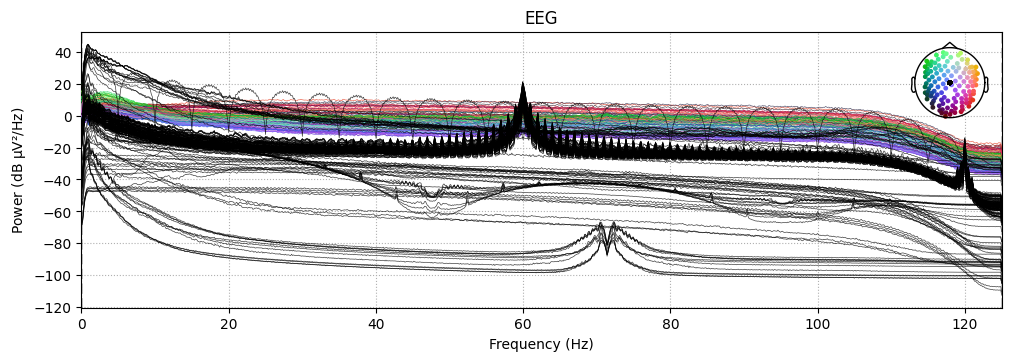

In [22]:
raw_eeg.plot_psd();

Чтение nii файла

In [23]:
nifti_img  = nib.load(anat_dirname + f'sub-{SUB_ID}_T1w.nii')

nii_data = nifti_img.get_fdata()
nii_aff  = nifti_img.affine
nii_hdr  = nifti_img.header

print(nii_aff ,'\n',nii_hdr)
print(nii_data.shape)

[[   1.     0.     0.  -127.5]
 [   0.     1.     0.  -127.5]
 [   0.     0.     1.  -127.5]
 [   0.     0.     0.     1. ]] 
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'          ')
db_name         : np.bytes_(b'                  ')
extents         : 0
session_error   : 0
regular         : np.bytes_(b' ')
dim_info        : 32
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 18
cal_max         : 3406.9807
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'FreeSurfer matlab                                       

Вид сверху-вниз

Slice 1


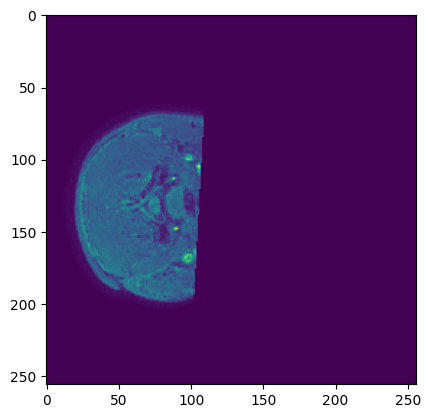

Slice 21


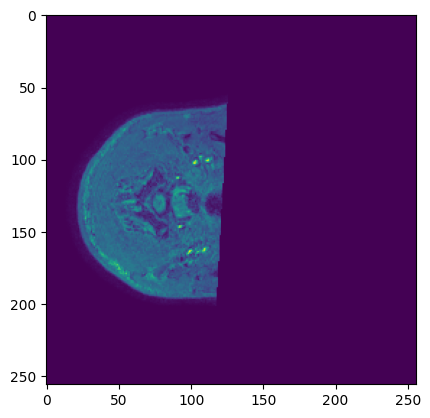

Slice 41


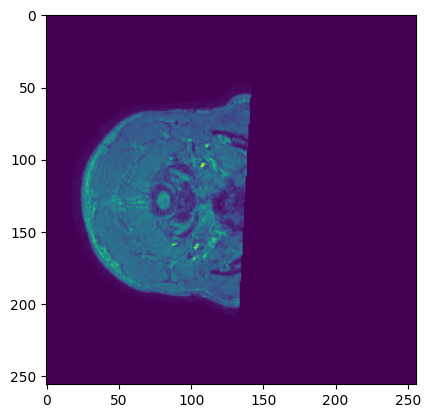

Slice 61


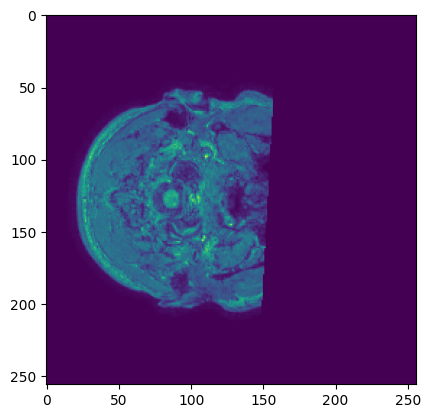

Slice 81


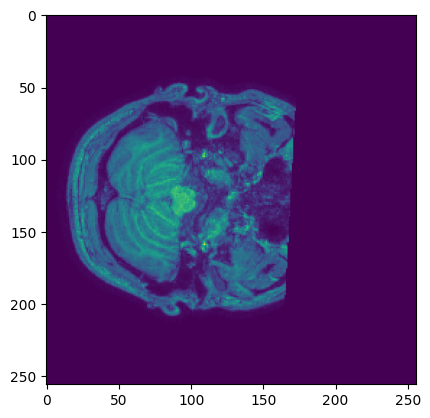

Slice 101


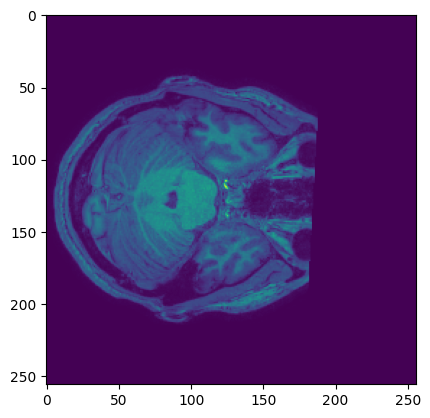

Slice 121


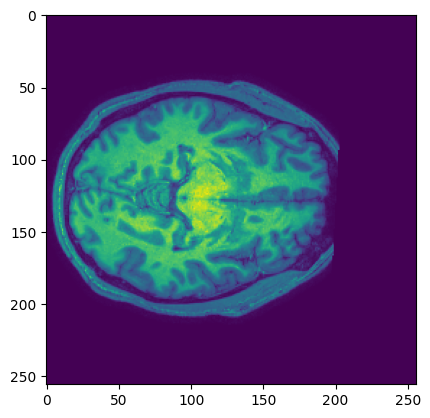

Slice 141


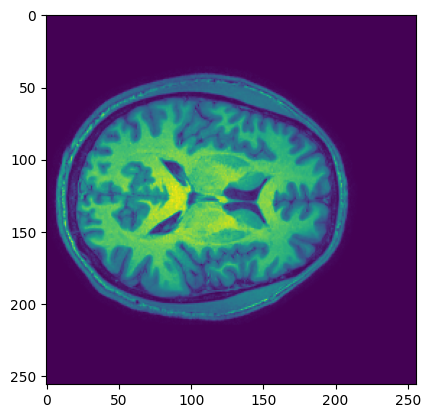

Slice 161


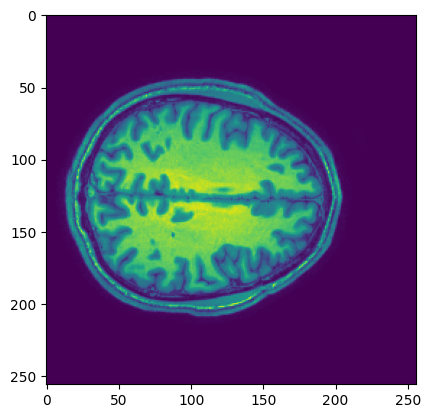

Slice 181


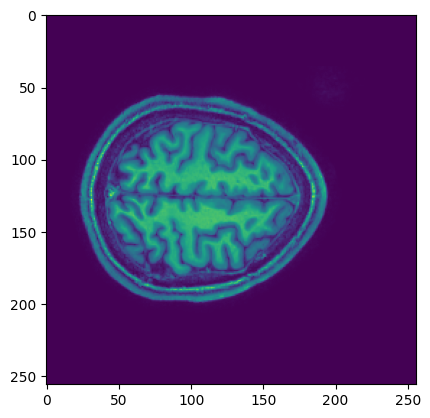

Slice 201


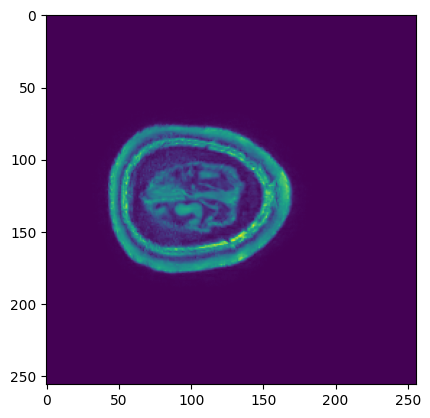

Slice 221


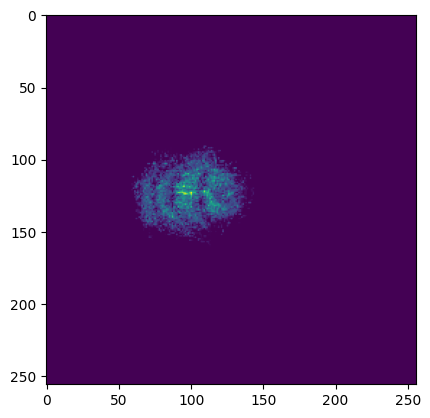

Slice 241


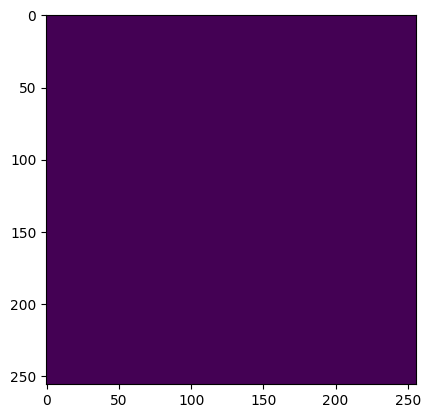

In [24]:
for slice_num in np.arange(0, nii_data.shape[2], 20):
   print(f"Slice {slice_num + 1}")
   plt.imshow(nii_data[:, :, slice_num])
   plt.show()

Вид назад-вперёд

Slice 1


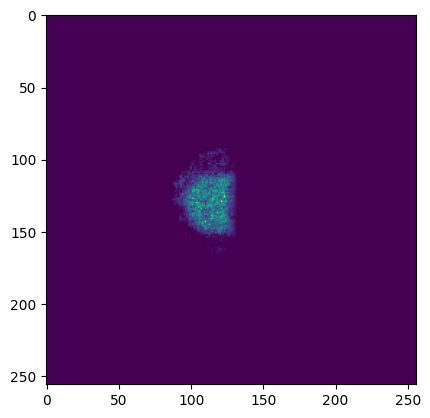

Slice 21


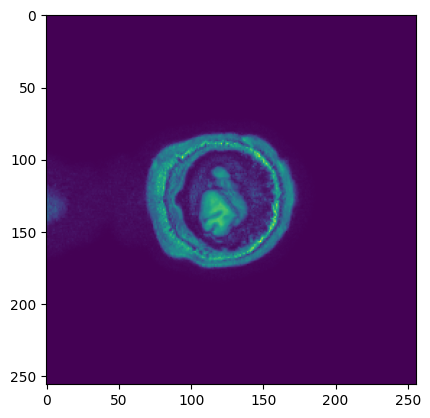

Slice 41


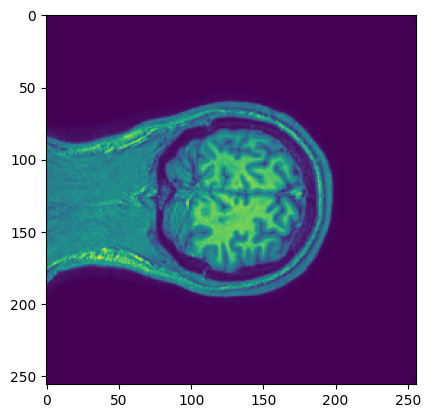

Slice 61


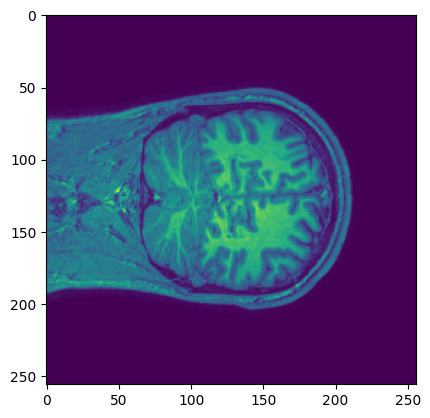

Slice 81


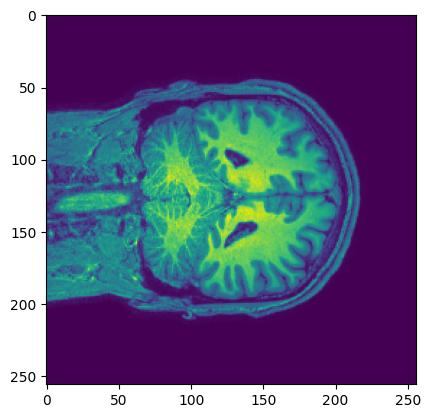

Slice 101


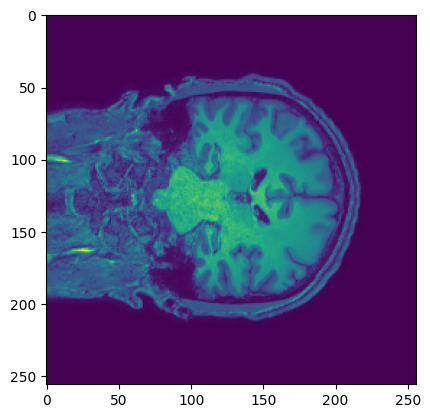

Slice 121


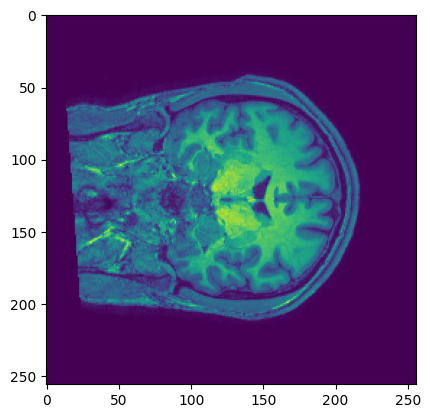

Slice 141


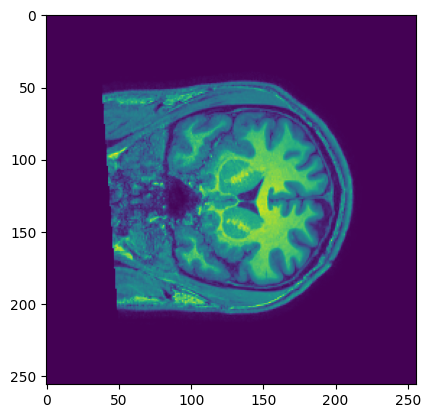

Slice 161


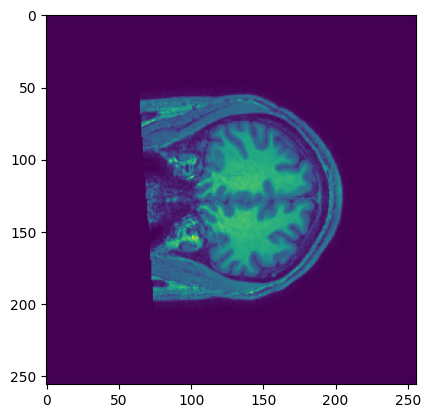

Slice 181


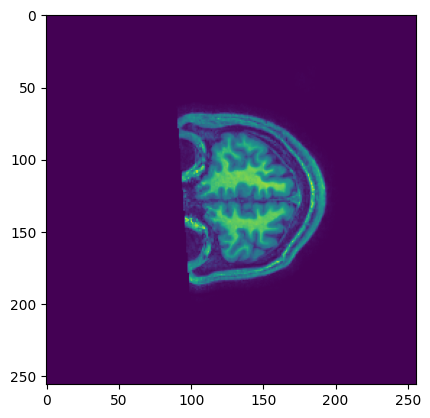

Slice 201


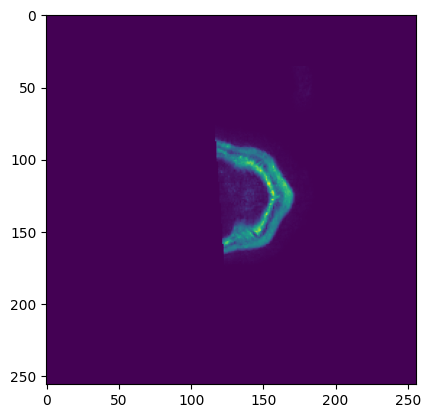

Slice 221


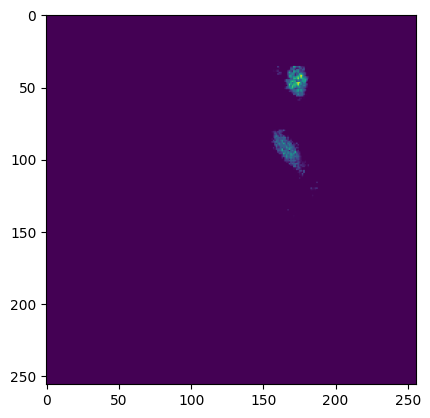

Slice 241


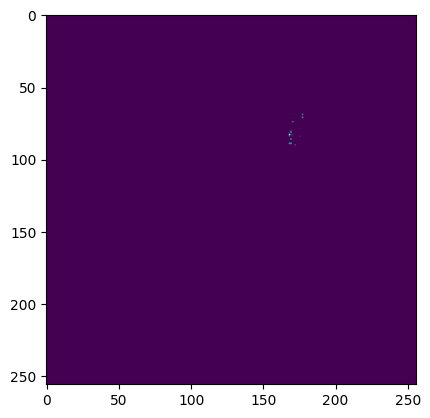

In [25]:
for slice_num in np.arange(0, nii_data.shape[1], 20):
   print(f"Slice {slice_num + 1}")
   plt.imshow(nii_data[:, slice_num, :])
   plt.show()

Вид справа-налево

Slice 1


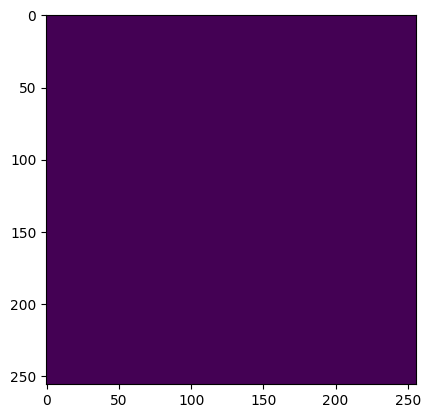

Slice 21


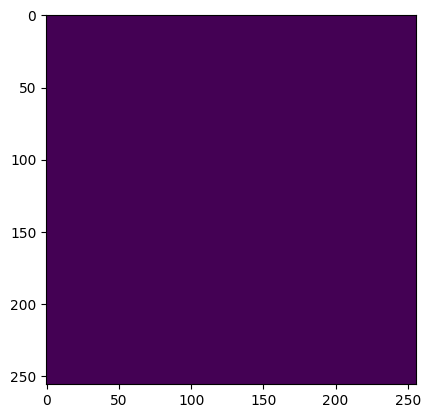

Slice 41


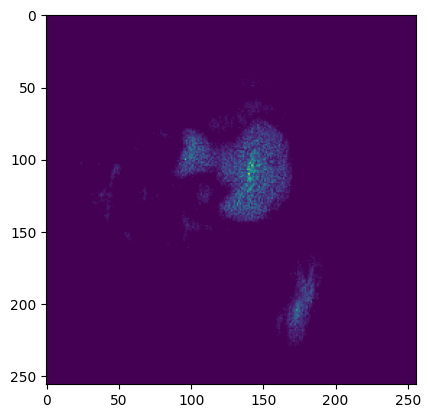

Slice 61


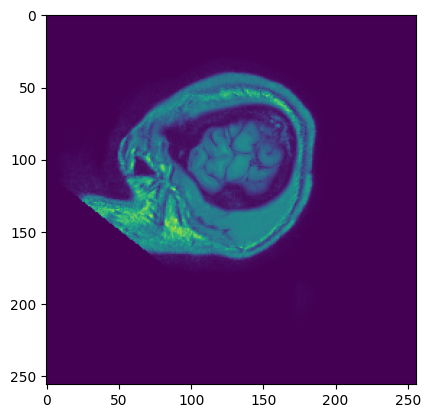

Slice 81


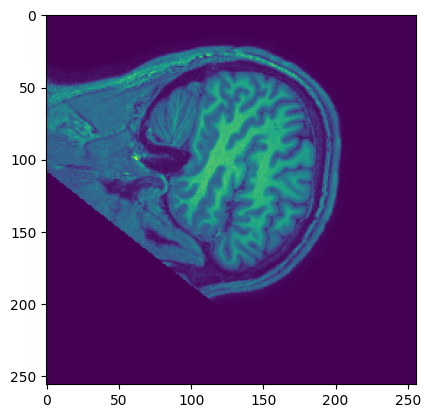

Slice 101


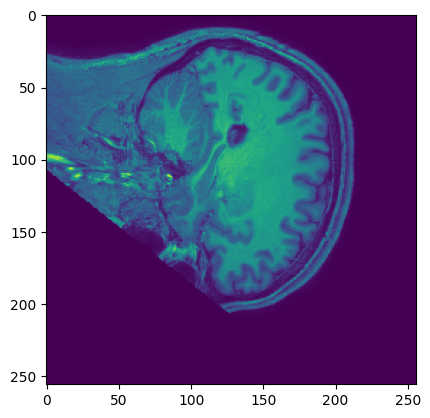

Slice 121


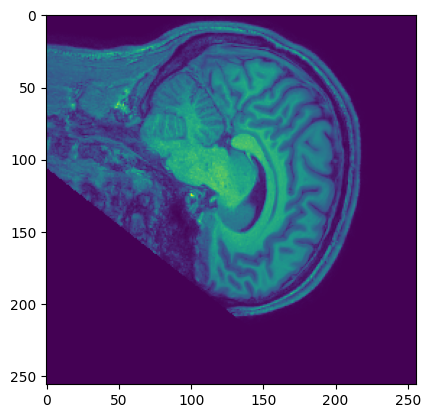

Slice 141


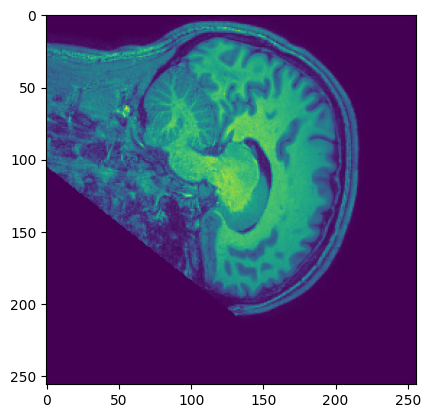

Slice 161


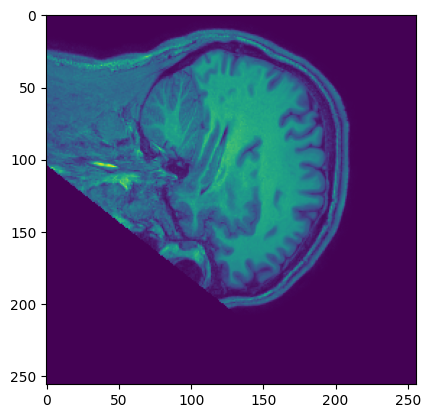

Slice 181


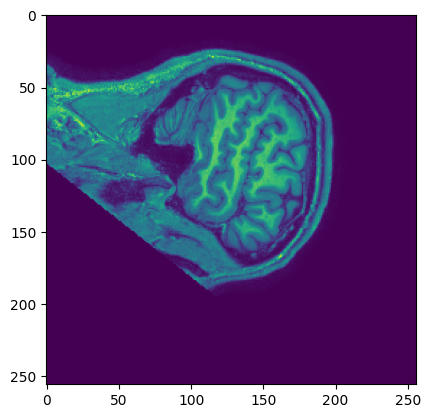

Slice 201


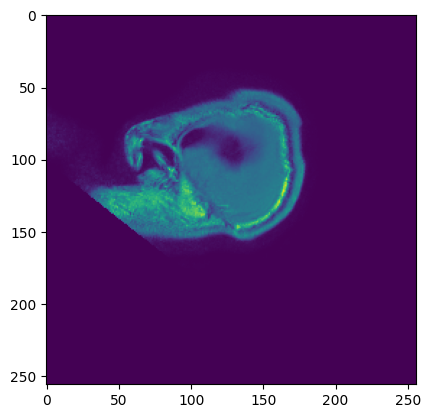

Slice 221


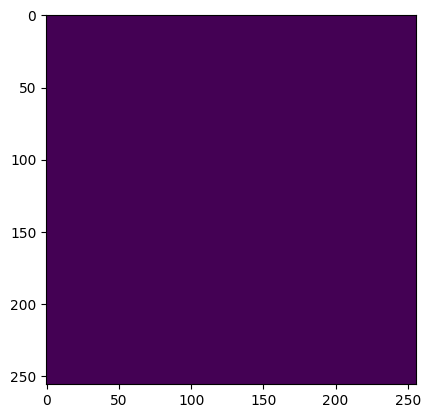

Slice 241


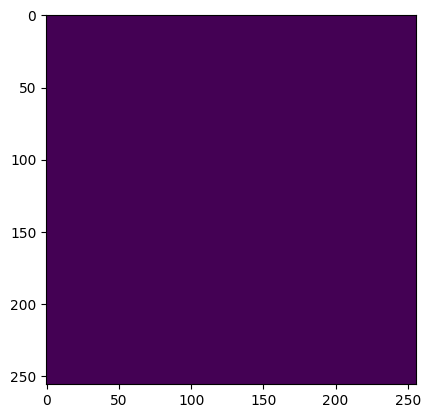

In [26]:
for slice_num in np.arange(0, nii_data.shape[0], 20):
   print(f"Slice {slice_num + 1}")
   plt.imshow(nii_data[slice_num, :, :])
   plt.show()

0 размерность -- вид сбоку

1 размерность -- вид сзади

2 размерность -- вид сверху

### Устанавливаем типы каналов

In [27]:
channels_df

name  type   units
0            Fp1   EEG  microV
1           AFp1   EEG  microV
2            AFz   EEG  microV
3            AF3   EEG  microV
4            AF7   EEG  microV
..           ...   ...     ...
307  Imu_2 :Y():  MISC     NaN
308  Imu_4 :Y():  MISC     NaN
309  Imu_1 :Z():  MISC     NaN
310  Imu_2 :Z():  MISC     NaN
311  Imu_4 :Z():  MISC     NaN

[312 rows x 3 columns]

In [28]:
channels_df.type.value_counts()

type
MISC    184
EEG     120
EMG       8
Name: count, dtype: int64

In [29]:
eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()

# Set channel types
channel_types = {}
for ch in raw_eeg.ch_names:
    if ch in eeg_channels:
        channel_types[ch] = 'eeg'
    elif ch in emg_channels:
        channel_types[ch] = 'emg'
    else:
        channel_types[ch] = 'misc'  # Includes IMU and other sensors

raw_eeg.set_channel_types(channel_types)

/tmp/ipykernel_3268665/49138378.py:15: RuntimeWarning: The unit for channel(s) BallMachine_Acc_X(g), BallMachine_Acc_Y(g), BallMachine_Acc_Z(g), CGY-x, CGY-y, CGY-z, CWR-x, CWR-y, CWR-z, Imu_1 :W():, Imu_1 :X():, Imu_1 :Y():, Imu_1 :Z():, Imu_1_ImuGyro :X(D/s):, Imu_1_ImuGyro :Y(D/s):, Imu_1_ImuGyro :Z(D/s):, Imu_1_ImuMag :X(uT):, Imu_1_ImuMag :Y(uT):, Imu_1_ImuMag :Z(uT):, Imu_2 :W():, Imu_2 :X():, Imu_2 :Y():, Imu_2 :Z():, Imu_2_ImuGyro :X(D/s):, Imu_2_ImuGyro :Y(D/s):, Imu_2_ImuGyro :Z(D/s):, Imu_2_ImuMag :X(uT):, Imu_2_ImuMag :Y(uT):, Imu_2_ImuMag :Z(uT):, Imu_4 :W():, Imu_4 :X():, Imu_4 :Y():, Imu_4 :Z():, Imu_4_ImuGyro :X(D/s):, Imu_4_ImuGyro :Y(D/s):, Imu_4_ImuGyro :Z(D/s):, Imu_4_ImuMag :X(uT):, Imu_4_ImuMag :Y(uT):, Imu_4_ImuMag :Z(uT):, N-AF3, N-AF4, N-AF7, N-AF8, N-AFF1h, N-AFF2h, N-AFF5h, N-AFF6h, N-AFp1, N-AFp2, N-AFz, N-C1, N-C2, N-C3, N-C4, N-C5, N-C6, N-CCP1h, N-CCP2h, N-CCP3h, N-CCP4h, N-CCP5h, N-CCP6h, N-CP1, N-CP2, N-CP3, N-CP4, N-CP5, N-CP6, N-CPP1h, N-CPP2h, N-CPP3

<RawEEGLAB | sub-09_task-TableTennis_eeg.fdt, 312 x 1146679 (4586.7 s), ~2.67 GB, data loaded>

Watch channels names

In [30]:
eeg_channels, misc_channels

(['Fp1',
  'AFp1',
  'AFz',
  'AF3',
  'AF7',
  'AFF5h',
  'AFF1h',
  'F1',
  'F3',
  'F5',
  'F7',
  'F9',
  'FFT9h',
  'FFT7h',
  'FFC5h',
  'FFC3h',
  'FFC1h',
  'FCz',
  'FC1',
  'FC3',
  'FC5',
  'FT7',
  'FT9',
  'FTT9h',
  'FTT7h',
  'FCC5h',
  'FCC3h',
  'FCC1h',
  'C1',
  'C3',
  'C5',
  'T7',
  'TTP7h',
  'CCP5h',
  'CCP3h',
  'CCP1h',
  'CP1',
  'CP3',
  'CP5',
  'TP7',
  'TPP9h',
  'TPP7h',
  'CPP5h',
  'CPP3h',
  'CPP1h',
  'P1',
  'P3',
  'P5',
  'P7',
  'PPO5h',
  'PPO1h',
  'POz',
  'PO3',
  'PO7',
  'PPO9h',
  'POO9h',
  'O1',
  'POO1',
  'OI1h',
  'Iz',
  'Cz',
  'C2',
  'C4',
  'C6',
  'T8',
  'FTT10h',
  'FTT8h',
  'FCC6h',
  'FCC4h',
  'FCC2h',
  'FC2',
  'FC4',
  'FC6',
  'FT8',
  'FT10',
  'FFT10h',
  'FFT8h',
  'FFC6h',
  'FFC4h',
  'FFC2h',
  'Fz',
  'F2',
  'F4',
  'F6',
  'F8',
  'F10',
  'AFF6h',
  'AFF2h',
  'AF4',
  'AF8',
  'FP2',
  'AFp2',
  'Oz',
  'OI2h',
  'POO10h',
  'O2',
  'POO2',
  'PO4',
  'PO8',
  'PPO10h',
  'PPO6h',
  'PPO2h',
  'Pz',
  'P2',


Заметим, что первые 120 misc каналов дублируют все 120 ЭЭГ каналов, но с префиксом `N-`

### EMG channels:

- 'LISCM', 'LSSCM'
- 'LITrap', 'LSTrap',
- 'RISCM', 'RSSCM',
- 'RITrap', 'RSTrap'

**Decoding the Abbreviations**

1. **Side of the Body**:
   - **`L`**: Left
   - **`R`**: Right

2. **Muscle Region or Part**:
   - **`I`**: Inferior (lower part)
   - **`S`**: Superior (upper part)

3. **Muscle Names**:
   - **`SCM`**: Sternocleidomastoid
   - **`Trap`**: Trapezius

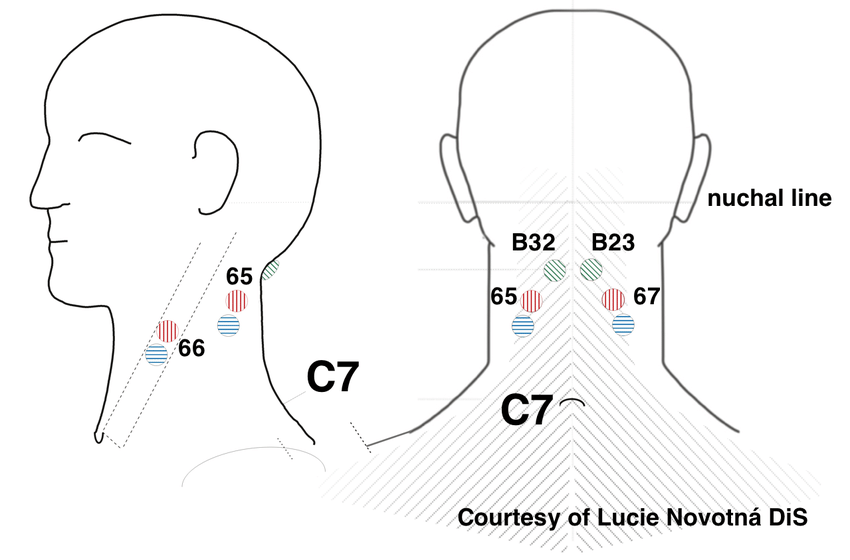

### Показания акселерометра:

- 'SyncPulse(uV)',
- 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)'
- 'BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)'
- 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)'


### Остальные каналы:

- **`C`**: Could represent **Cap** or **Central**
- **`N`**: Likely stands for **Noise** or **Neck**
- **`GY`**: **Gyroscope** data
- **`WR`**: **Wearable** or **Wrist** data


1. **`CGY-x`, `CGY-y`, `CGY-z`**:
   - **Meaning**: **Cap Gyroscope X, Y, Z axes**
   - **Location**: Likely gyroscope sensors placed on the EEG cap.
   - **Function**: Measure rotational movements of the head along the three axes.

2. **`CWR-x`, `CWR-y`, `CWR-z`**:
   - **Meaning**: **Cap Wearable/Wrist Accelerometer X, Y, Z axes**
   - **Location**: Possibly accelerometer sensors on the EEG cap or worn on the wrist.
   - **Function**: Measure linear accelerations, such as head movements or wrist movements if worn on the wrist.

3. **`NGY-x`, `NGY-y`, `NGY-z`**:
   - **Meaning**: **Noise Gyroscope X, Y, Z axes** or **Neck Gyroscope X, Y, Z axes**
   - **Location**: Gyroscope sensors near noise electrodes or on the neck.
   - **Function**: Capture rotational movements that may be considered noise or provide additional data on neck movements.

4. **`NWR-x`, `NWR-y`, `NWR-z`**:
   - **Meaning**: **Noise Wearable/Wrist Accelerometer X, Y, Z axes** or **Neck Wearable**
   - **Location**: Accelerometer sensors associated with noise electrodes or placed on the neck or wrist.
   - **Function**: Measure linear accelerations related to noise or specific body parts.


### Решаем, что делать с пропусками в датафрейме с позициями электродов

In [31]:
electrodes_df

name       x      y      z
0            Fp1   95.84  46.55  56.45
1           AFp1  107.08  23.21  67.14
2            AFz   97.28  24.95  87.40
3            AF3   87.54  43.14  82.39
4            AF7   72.94  63.65  52.12
..           ...     ...    ...    ...
307  Imu_2 :Y():     NaN    NaN    NaN
308  Imu_4 :Y():     NaN    NaN    NaN
309  Imu_1 :Z():     NaN    NaN    NaN
310  Imu_2 :Z():     NaN    NaN    NaN
311  Imu_4 :Z():     NaN    NaN    NaN

[312 rows x 4 columns]

In [32]:
electrodes_df.name[electrodes_df.x.notna()]

0        Fp1
1       AFp1
2        AFz
3        AF3
4        AF7
       ...  
115      TP8
116    TTP8h
117    CCP6h
118    CCP4h
119    CCP2h
Name: name, Length: 120, dtype: object

Нетрудно заметить, что позиции электродов не указаны у не-ЭЭГ датчиков, что очевидно.

Поэтому можем их спокойно удалить.

In [33]:
electrodes_df.dropna(inplace=True)

### Извлекаем события и создаём аннотации

In [34]:
annotations = raw_eeg.annotations
events, event_id = mne.events_from_annotations(raw_eeg)

Used Annotations descriptions: [np.str_('M  1'), np.str_('Subject_hit'), np.str_('Subject_receive'), np.str_('boundary')]


In [35]:
annotations

<Annotations | 2978 segments: M 1 (822), Subject_hit (1403), ...>

In [36]:
events.shape, events

((2978, 3),
 array([[     22,       0,       1],
        [   1320,       0,       1],
        [   2618,       0,       1],
        ...,
        [1066286,       0,       2],
        [1066825,       0,       2],
        [1067086,       0,       1]]))

In [37]:
Counter(events[:, 1])

Counter({np.int64(0): 2978})

In [38]:
Counter(events[:, 2])

Counter({np.int64(2): 1403,
         np.int64(1): 822,
         np.int64(3): 736,
         np.int64(4): 17})

### Визуализация

Effective window size : 8.192 (s)


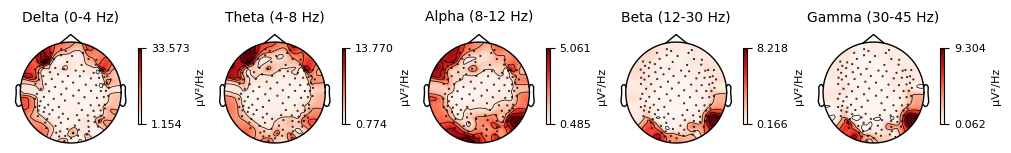

In [39]:
raw_eeg.compute_psd().plot_topomap();

Effective window size : 8.192 (s)


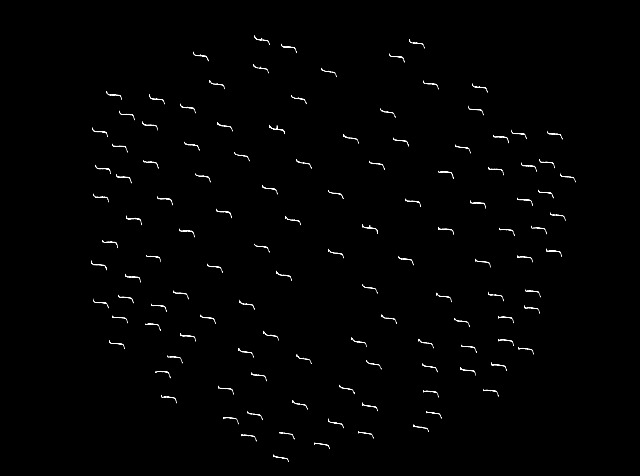

In [40]:
raw_eeg.compute_psd().plot_topo();

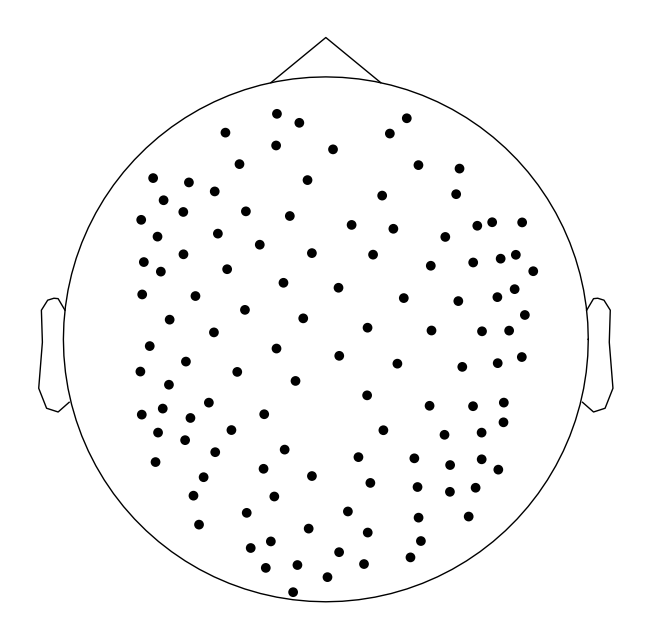

In [41]:
raw_eeg.plot_sensors();

Извлекаем сессии игры с исследователем

In [42]:
annotations.description

array(['M  1', 'M  1', 'M  1', ..., 'Subject_hit', 'Subject_hit', 'M  1'],
      dtype='<U15')

Join target data

In [43]:
eeg_file = os.path.join(eeg_dirname, f'sub-{SUB_ID}_task-TableTennis_eeg.set')
mat = scipy.io.loadmat(eeg_file, struct_as_record=False, squeeze_me=True)

events_df['bounces'] = None
events_df['performance'] = None
events_df['device'] = None
events_df['orignum'] = None
events_df.drop(columns=['duration', 'response_time', 'stim_file'], inplace=True, errors='ignore')

empty_array = np.array([])

for i, row in events_df.iterrows():
    mat_event = mat['event'][i]
    
    assert mat_event.type == row['value'], "asynchronous status event_type"
    assert row['trial_type'] == 'STATUS' or mat_event.condlabel == row['trial_type'], "asynchronous status"
    assert np.abs(mat_event.latency - row['sample']) <= 2, "asynchronous time"
    
    if not isinstance(mat_event.bounces, np.ndarray):
        events_df.at[i, 'bounces'] = mat_event.bounces

    if not isinstance(mat_event.performance, np.ndarray):
        events_df.at[i, 'performance'] = mat_event.performance

    if not isinstance(mat_event.code, np.ndarray):
        events_df.at[i, 'device'] = mat_event.code

    if not isinstance(mat_event.orignum, np.ndarray):
        events_df.at[i, 'orignum'] = mat_event.orignum

# mat['event'][200].bounces,\
# mat['event'][200].code,\
# mat['event'][200].condlabel,\
# mat['event'][200].latency,\
# mat['event'][200].orignum,\
# mat['event'][200].performance,\
# mat['event'][200].type

Look at events dataframe with target

In [44]:
events_df.query("trial_type in ('competitive', 'cooperative')")[['value', 'bounces']].value_counts()

value            bounces      
Subject_receive  1Bounce_Human    589
Subject_hit      1Bounce_Human    476
Subject_receive  2Bounce_Human    147
Subject_hit      2Bounce_Human    145
                 Serve_Human       55
Name: count, dtype: int64

In [45]:
events_subdf = events_df.query("trial_type in ('competitive')")

for i in range(0, events_subdf.shape[0], 60):
    print(events_subdf.iloc[i:i+60, [0,1,3,4,5,7]])

         onset    sample            value        bounces performance orignum
1198  1980.956  495239.0  Subject_receive  2Bounce_Human           1       1
1199  1981.024  495256.0             M  1           None        None    None
1200  1981.688  495422.0      Subject_hit  2Bounce_Human           3       2
1201  1985.796  496449.0  Subject_receive  2Bounce_Human           1       3
1202  1986.216  496554.0             M  1           None        None    None
1203  1986.640  496660.0      Subject_hit  2Bounce_Human           1       4
1204  1987.076  496769.0  Subject_receive  1Bounce_Human           1       5
1205  1987.744  496936.0      Subject_hit  1Bounce_Human           1       6
1206  1987.964  496991.0  Subject_receive  1Bounce_Human           1       7
1207  1989.376  497344.0      Subject_hit  1Bounce_Human           1       8
1208  1991.408  497852.0             M  1           None        None    None
1209  1994.944  498736.0  Subject_receive  2Bounce_Human           1       9

`Subject_hit` or `Subject_receive` in **competitive**  esssions

In [46]:
event_types_of_interest = ['Subject_hit', 'Subject_receive']
filtered_events_df = events_df\
    .query("value in ('Subject_hit', 'Subject_receive')")\
    .query("trial_type in ('competitive')")\
    .query("performance == 1")

participant_acc_channels = [
    'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)',
    'Participant_Paddle_Acc_Z(g)'
]
researcher_acc_channels = [
    'Researcher_Paddle_Acc_X(g)',
    'Researcher_Paddle_Acc_Y(g)',
    'Researcher_Paddle_Acc_Z(g)'
]
acc_channels = participant_acc_channels + researcher_acc_channels
acc_data = raw_eeg.copy().pick_channels(acc_channels)

sfreq = raw_eeg.info['sfreq']
tmin = -0.5  # seconds before the event
tmax = 0.5   # seconds after the event
window_size = int((tmax - tmin) * sfreq)  # Number of samples in the window

# Convert onset times to sample indices
filtered_events_df['sample_index'] = (filtered_events_df['onset'] * sfreq + 0.5).astype(int)

# Initialize dictionaries to store data
data_hit = []
data_receive = []

# Time vector for plotting
time_vector = np.linspace(tmin, tmax, window_size, endpoint=False)

# Loop over events
for idx, row in filtered_events_df.iterrows():
    event_type = row['value']
    sample_index = row['sample_index']
    
    # Calculate start and end indices for the window
    start_index = sample_index + int(tmin * sfreq)
    end_index = start_index + window_size
    
    # Handle cases where indices are out of bounds
    if start_index < 0 or end_index > acc_data.n_times:
        continue  # Skip this event if the window is out of bounds
    
    # Extract data segment
    data_segment = acc_data.get_data(start=start_index, stop=end_index)
    
    # Append to the appropriate list
    if event_type == 'Subject_hit':
        data_hit.append(data_segment)
    elif event_type == 'Subject_receive':
        data_receive.append(data_segment)

gc.collect()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


39941

Plot accelerometer during competitive session

In [131]:
from ipywidgets import interact, FloatSlider, Layout


event_types_of_interest = ['Subject_hit', 'Subject_receive']
competitive_events_df = events_df\
    .query("value in ('Subject_hit', 'Subject_receive')")\
    .query("trial_type in ('competitive', 'cooperative')")

participant_acc_channels = [
    'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)',
    'Participant_Paddle_Acc_Z(g)'
]
researcher_acc_channels = [
    'Researcher_Paddle_Acc_X(g)',
    'Researcher_Paddle_Acc_Y(g)',
    'Researcher_Paddle_Acc_Z(g)'
]
acc_channels = participant_acc_channels + researcher_acc_channels
acc_data = raw_eeg.copy().pick_channels(acc_channels)
acc_times = acc_data.times
acc_values = acc_data.get_data()

# acc_values = acc_values[:]

participant_hits = competitive_events_df[competitive_events_df['value'] == 'Subject_hit']['onset'].values
scientist_hits = competitive_events_df[competitive_events_df['value'] == 'Subject_receive']['onset'].values

# EEG shift in seconds
SHIFT = 55010 / 250

# Define the interactive plotting function
def plot_accelerometer_data(start_time=0.0, duration=10.0):
    # Calculate end time
    end_time = start_time + duration
    start_time += SHIFT
    end_time += SHIFT

    # Find indices corresponding to the start and end times
    start_idx = np.searchsorted(acc_times, start_time)
    end_idx = np.searchsorted(acc_times, end_time)

    # Extract data for the time window
    time_window = acc_times[start_idx:end_idx]
    acc_values_window = acc_values[:, start_idx:end_idx]

    # Create the plot
    fig, axs = plt.subplots(len(acc_channels), 1, figsize=(12, 8), sharex=True)

    for idx, ch_name in enumerate(acc_channels):
        axs[idx].plot(time_window - SHIFT, acc_values_window[idx, :], label=ch_name)
        axs[idx].set_ylabel('Acceleration (g)')
        axs[idx].legend(loc='upper right')
        axs[idx].grid(True)

        # Mark participant's hit moments
        for hit_time in participant_hits:
            if idx < 3 and start_time <= hit_time + SHIFT <= end_time:
                axs[idx].axvline(x=hit_time, color='blue', linestyle='--')

        # Mark scientist's hit moments
        for hit_time in scientist_hits:
            if idx >= 3 and start_time <= hit_time + SHIFT <= end_time:
                axs[idx].axvline(x=hit_time, color='green', linestyle='--')

    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Create interactive widgets for start time and duration
max_time = acc_times[-1]

start_time_slider = FloatSlider(
    min=0.0,
    max=max_time - 1.0,  # Subtract 1.0 to allow for duration
    step=2.0,
    value=1981.0,
    description='Start Time (s)',
    layout=Layout(width='800px')  # Increase the width of the slider
)

duration_slider = FloatSlider(
    min=1.0,
    max=90.0,
    step=1.0,
    value=45.0,
    description='Duration (s)',
    layout=Layout(width='800px')  # Increase the width of the slider
)

# Use interact to create interactive plot
interact(
    plot_accelerometer_data,
    start_time=start_time_slider,
    duration=duration_slider
)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


interactive(children=(FloatSlider(value=1981.0, description='Start Time (s)', layout=Layout(width='800px'), ma…

<function __main__.plot_accelerometer_data(start_time=0.0, duration=10.0)>

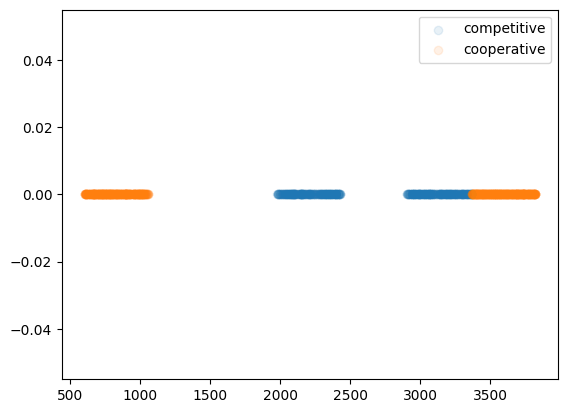

In [112]:
competitive_onset_values = competitive_events_df.query("trial_type == 'competitive'").onset
cooperative_onset_values = competitive_events_df.query("trial_type == 'cooperative'").onset

plt.scatter(competitive_onset_values, np.zeros_like(competitive_onset_values), alpha=0.1, label='competitive')
plt.scatter(cooperative_onset_values, np.zeros_like(cooperative_onset_values), alpha=0.1, label='cooperative')
plt.legend()
plt.show()

In [128]:
sessions_start = sorted([
    competitive_onset_values.iloc[0],
    cooperative_onset_values.iloc[0],
    competitive_onset_values[
        competitive_onset_values.diff().sort_values().index[-2]
    ],
    cooperative_onset_values[
        cooperative_onset_values.diff().sort_values().index[-2]
    ],
])
sessions_end = sorted([
    competitive_onset_values.iloc[-1],
    cooperative_onset_values.iloc[-1],
    competitive_onset_values[::-1][
        competitive_onset_values[::-1].diff().sort_values().index[0]
    ],
    cooperative_onset_values[::-1][
        cooperative_onset_values[::-1].diff().sort_values().index[0]
    ],
])

sessions_arr = list(zip(sessions_start, sessions_end))
sessions_arr

[(np.float64(605.012), np.float64(1056.988)),
 (np.float64(1980.956), np.float64(2427.956)),
 (np.float64(2902.68), np.float64(3360.972)),
 (np.float64(3364.976), np.float64(3820.568))]

Defining time shift via XXX

In [55]:
acc_ttl_data = np.sqrt(np.sum(np.square(acc_values[:3]), axis=0))

labels_data = np.zeros_like(acc_ttl_data)
hit_indices = (events_df.query("value == 'Subject_hit'")['sample'] + 0.5).astype(int)
labels_data[hit_indices.values] = 1

In [56]:
from multiprocessing import Pool


def calculate_corr(i):
    return np.corrcoef(acc_ttl_data[i:], labels_data[:labels_data.size-i])[0, 1]

with Pool() as pool:
    cross_corr_arr = list(tqdm(pool.imap(calculate_corr, range(acc_ttl_data.size // 10)), total=acc_ttl_data.size // 10))

  0%|          | 0/114667 [00:00<?, ?it/s]

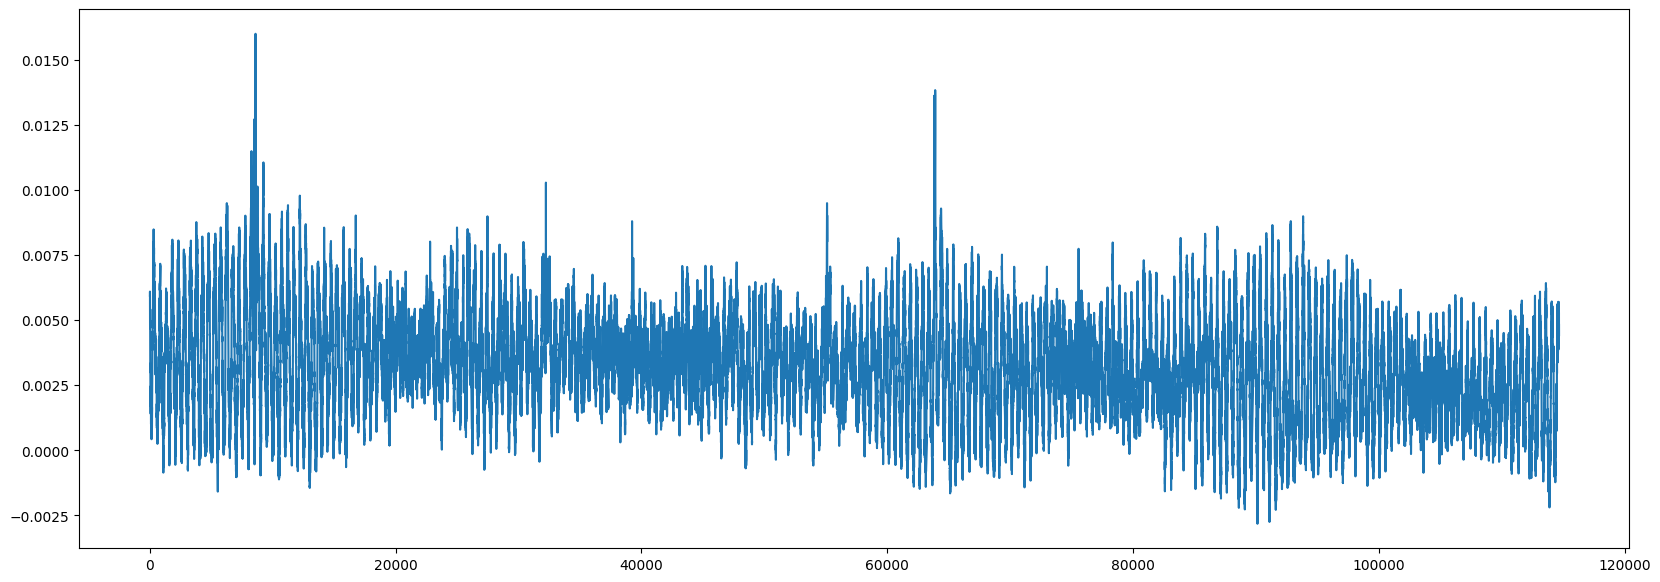

In [57]:
plt.figure(figsize=(20, 7))
plt.plot(cross_corr_arr)
plt.show()

In [58]:
np.argsort(cross_corr_arr)[::-1][:10]

array([ 8593,  8592, 63901, 63905, 63902, 63908, 63810, 63907, 63904,
       63906])

In [59]:
from multiprocessing import Pool


def calculate_cov(i):
    return np.dot(acc_ttl_data[i:], labels_data[:labels_data.size-i])


with Pool() as pool:
    cross_cov_arr = list(tqdm(pool.imap(calculate_cov, range(8 * 60 * 250)), total=8 * 60 * 250))

  0%|          | 0/120000 [00:00<?, ?it/s]

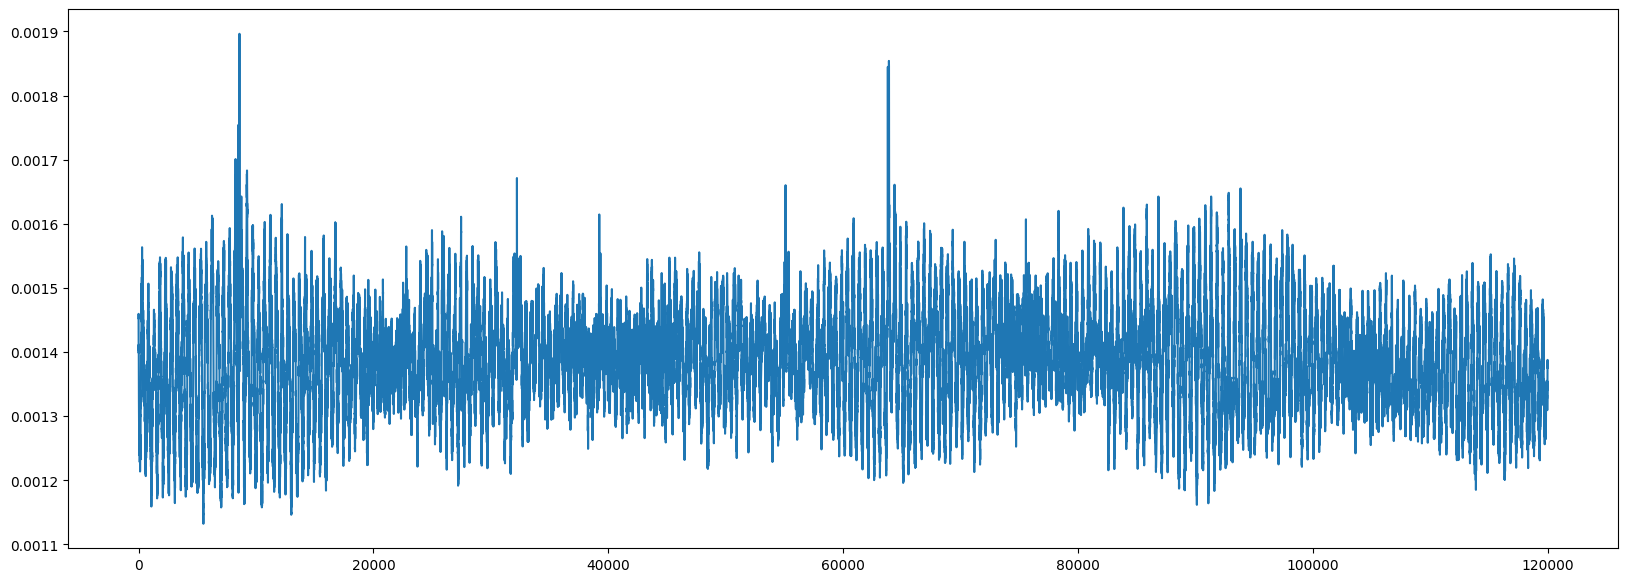

array([ 8593, 63901, 63905, 63902, 63908])

In [60]:
plt.figure(figsize=(20, 7))
plt.plot(cross_cov_arr)
plt.show()

np.argsort(cross_cov_arr)[::-1][:5]

## Define target

For **Subject_hit**:

1. Success (1): `performance == 1` and time_diff > 4 seconds
2. Neutral (0): `performance == 1` and time_diff <= 4 seconds
3. Negative (-1): `performance in (2. 3)`
4. Last non-negative (2): last neutral hit before negative one

In [61]:
def define_successful_hit(events_df: pd.DataFrame, result_col: str = 'score') -> pd.DataFrame:
    df = events_df.copy()
    df.dropna(subset=['orignum'], inplace=True)
    df = df.query(
        "trial_type in ('cooperative', 'competitive')"
    ).assign(
        timedelta=df.query("value != 'M  1'").onset.diff(periods=-1).abs()
    )
    df = df.assign(
        session_end=df.timedelta > 4
    )
    
    df['score'] = None
    index = df.index

    df.loc[index[df.performance.isin([2, 3])], 'score'] = -1
    df.loc[index[(df.session_end) & (df.performance == 1)], 'score'] = 1
    df.loc[index[(~df.session_end) & (df.performance == 1)], 'score'] = 0
    df.loc[index[(df.score == 0) & (df.score.shift(-1) == -1)], 'score'] = 2

    df.drop(columns=['session_end', 'timedelta'], inplace=True)
    return df


events_df_with_trg = define_successful_hit(events_df)
events_df_with_trg.dropna(subset=['score'], inplace=True)

In [ ]:
events_df_with_trg.query("trial_type == 'competitive'").iloc[:60]

In [ ]:
events_df_with_trg.score.value_counts()

## Collect EEG + IMU for target

Get channels which exist for all participants

In [ ]:
channels_df_all = []
sub_ids = ['0' * (n < 10) + str(n) for n in range(1, 26)]
prev_chnl_df = None

for sub_id in sub_ids:
    eeg_dir = os.path.join(DATA_PATH, f'sub-{sub_id}', 'eeg/')
    chnl_df = pd.read_csv(eeg_dir + f'sub-{sub_id}_task-TableTennis_channels.tsv', sep='\t')
    chnl_df.drop(columns=['units'], inplace=True)
    
    if prev_chnl_df is None:
        prev_chnl_df = chnl_df
        continue

    prev_chnl_df = pd.merge(prev_chnl_df, chnl_df, on=['name', 'type'])
    gc.collect()

In [ ]:
events_df_with_trg

In [ ]:
prev_chnl_df.query(
    "name not in ("
    "'SyncPulse(uV)', 'BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', "
    "'BallMachine_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', "
    "'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)')"
).name.values

In [ ]:
participant_channels = prev_chnl_df.query(
    "name not in ("
    "'SyncPulse(uV)', 'BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', "
    "'BallMachine_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', "
    "'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)')"
).name.values
researcher_channels = [
    'Researcher_Paddle_Acc_X(g)',
    'Researcher_Paddle_Acc_Y(g)',
    'Researcher_Paddle_Acc_Z(g)'
]
acc_channels = participant_acc_channels + researcher_acc_channels
acc_data = raw_eeg.copy().pick_channels(acc_channels)

sfreq = raw_eeg.info['sfreq']
tmin = -0.5  # seconds before the event
tmax = 0.0   # seconds after the event
window_size = int((tmax - tmin) * sfreq)  # Number of samples in the window

# Initialize dictionaries to store data
data_hit = []
data_receive = []

# Time vector for plotting
time_vector = np.linspace(tmin, tmax, window_size, endpoint=False)

# Loop over events
for idx, row in events_df_with_trg.iterrows():
    event_type = row['value']
    sample_index = int(row['sample'] + 0.5)
    
    # Calculate start and end indices for the window
    start_index = sample_index + int(tmin * sfreq)
    end_index = start_index + window_size
    
    # Handle cases where indices are out of bounds
    if start_index < 0 or end_index > acc_data.n_times:
        continue  # Skip this event if the window is out of bounds
    
    # Extract data segment
    data_segment = acc_data.get_data(start=start_index, stop=end_index)
    
    # Append to the appropriate list
    if event_type == 'Subject_hit':
        data_hit.append(data_segment[:-3])
    elif event_type == 'Subject_receive':
        data_receive.append(data_segment[-3:])

gc.collect()

Data structure: sub-id, event-id, event-details, event-info

In [ ]:
len(data_hit), data_hit[0].shape

In [ ]:
!mkdir -p final_sample

In [ ]:
data_hit_npy = np.array(data_hit)

events_df_data_hit = events_df_with_trg.query("value == 'Subject_hit'")
data_hit_target = events_df_data_hit.score.values
data_hit_timesteps = events_df_data_hit.onset.values

np.savez_compressed(
    'final_sample/signals_09.npz',
    signals=data_hit_npy,
    target=data_hit_target,
    timesteps=data_hit_timesteps,
    channels=participant_channels
)

del data_hit_npy
gc.collect()

# data = np.load('final_sample/signals_09.npz')['eeg_data']

## Итоговый код для сбора выборки

In [23]:
def define_successful_hit(events_df: pd.DataFrame, result_col: str = 'score') -> pd.DataFrame:
    df = events_df.copy()
    df.dropna(subset=['orignum'], inplace=True)
    df = df.query(
        "trial_type in ('cooperative', 'competitive')"
    ).assign(
        timedelta=df.query("value != 'M  1'").onset.diff(periods=-1).abs()
    )
    df = df.assign(
        session_end=df.timedelta > 4
    )
    
    df['score'] = None
    index = df.index

    df.loc[index[df.performance.isin([2, 3])], 'score'] = -1
    df.loc[index[(df.session_end) & (df.performance == 1)], 'score'] = 1
    df.loc[index[(~df.session_end) & (df.performance == 1)], 'score'] = 0
    df.loc[index[(df.score == 0) & (df.score.shift(-1) == -1)], 'score'] = 2

    df.drop(columns=['session_end', 'timedelta'], inplace=True)
    return df

In [25]:
DATA_PATH = '/data/kazachkovda/realWorldTableTennis'
PARTICIPANT_CHANNELS = [
    'Fp1', 'AFp1', 'AFz', 'AF3', 'AF7', 'AFF5h', 'AFF1h', 'F1', 'F3',
    'F5', 'F7', 'F9', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h',
    'FCz', 'FC1', 'FC3', 'FC5', 'FT7', 'FT9', 'FTT9h', 'FTT7h',
    'FCC5h', 'FCC3h', 'FCC1h', 'C1', 'C3', 'C5', 'T7', 'TTP7h',
    'CCP5h', 'CCP3h', 'CCP1h', 'CP1', 'CP3', 'CP5', 'TP7', 'TPP9h',
    'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'P1', 'P3', 'P5', 'P7',
    'PPO5h', 'PPO1h', 'POz', 'PO3', 'PO7', 'PPO9h', 'O1', 'POO1',
    'OI1h', 'Iz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'FTT10h', 'FTT8h',
    'FCC6h', 'FCC4h', 'FCC2h', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
    'FFT10h', 'FFT8h', 'FFC6h', 'FFC4h', 'FFC2h', 'Fz', 'F2', 'F4',
    'F6', 'F8', 'F10', 'AFF6h', 'AFF2h', 'AF4', 'AF8', 'FP2', 'AFp2',
    'Oz', 'OI2h', 'POO10h', 'O2', 'POO2', 'PO4', 'PO8', 'PPO10h',
    'PPO6h', 'PPO2h', 'Pz', 'P2', 'P4', 'P6', 'P8', 'TPP10h', 'TPP8h',
    'CPP6h', 'CPP4h', 'CPP2h', 'CP2', 'CP4', 'CP6', 'TP8', 'TTP8h',
    'CCP6h', 'CCP4h', 'CCP2h', 'N-Fp1', 'N-AFp1', 'N-AFz', 'N-AF3',
    'N-AF7', 'N-AFF5h', 'N-AFF1h', 'N-F1', 'N-F3', 'N-F5', 'N-F7',
    'N-F9', 'N-FFT9h', 'N-FFT7h', 'N-FFC5h', 'N-FFC3h', 'N-FFC1h',
    'N-FCz', 'N-FC1', 'N-FC3', 'N-FC5', 'N-FT7', 'N-FT9', 'N-FTT9h',
    'N-FTT7h', 'N-FCC5h', 'N-FCC3h', 'N-FCC1h', 'N-C1', 'N-C3', 'N-C5',
    'N-T7', 'N-TTP7h', 'N-CCP5h', 'N-CCP3h', 'N-CCP1h', 'N-CP1',
    'N-CP3', 'N-CP5', 'N-TP7', 'N-TPP9h', 'N-TPP7h', 'N-CPP5h',
    'N-CPP3h', 'N-CPP1h', 'N-P1', 'N-P3', 'N-P5', 'N-P7', 'N-PPO5h',
    'N-PPO1h', 'N-POz', 'N-PO3', 'N-PO7', 'N-PPO9h', 'N-O1', 'N-POO1',
    'N-OI1h', 'N-Iz', 'N-Cz', 'N-C2', 'N-C4', 'N-C6', 'N-T8',
    'N-FTT10h', 'N-FTT8h', 'N-FCC6h', 'N-FCC4h', 'N-FCC2h', 'N-FC2',
    'N-FC4', 'N-FC6', 'N-FT8', 'N-FT10', 'N-FFT10h', 'N-FFT8h',
    'N-FFC6h', 'N-FFC4h', 'N-FFC2h', 'N-Fz', 'N-F2', 'N-F4', 'N-F6',
    'N-F8', 'N-F10', 'N-AFF6h', 'N-AFF2h', 'N-AF4', 'N-AF8', 'N-FP2',
    'N-AFp2', 'N-Oz', 'N-OI2h', 'N-POO10h', 'N-O2', 'N-POO2', 'N-PO4',
    'N-PO8', 'N-PPO10h', 'N-PPO6h', 'N-PPO2h', 'N-Pz', 'N-P2', 'N-P4',
    'N-P6', 'N-P8', 'N-TPP10h', 'N-TPP8h', 'N-CPP6h', 'N-CPP4h',
    'N-CPP2h', 'N-CP2', 'N-CP4', 'N-CP6', 'N-TP8', 'N-TTP8h',
    'N-CCP6h', 'N-CCP4h', 'N-CCP2h', 'LISCM', 'LSSCM', 'LSTrap',
    'LITrap', 'CGY-x', 'CGY-y', 'CGY-z', 'RITrap', 'RISCM', 'RSSCM',
    'RSTrap', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z',
    'NWR-x', 'NWR-y', 'NWR-z', 'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)'
]
T_LEN = 0.5

SUB_IDS = ['01'] # ['0' * (n < 10) + str(n) for n in range(1, 26)]

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
    eeg_file = os.path.join(eeg_dirname, f'sub-{SUB_ID}_task-TableTennis_eeg.set')
    mat = scipy.io.loadmat(eeg_file, struct_as_record=False, squeeze_me=True)
    
    eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
    emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
    misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()
    
    # Set channel types
    channel_types = {}
    for ch in raw_eeg.ch_names:
        if ch in eeg_channels:
            channel_types[ch] = 'eeg'
        elif ch in emg_channels:
            channel_types[ch] = 'emg'
        else:
            channel_types[ch] = 'misc'  # Includes IMU and other sensors
    
    raw_eeg.set_channel_types(channel_types)
    
    events_df['bounces'] = None
    events_df['performance'] = None
    events_df['device'] = None
    events_df['orignum'] = None
    
    for i, row in events_df.iterrows():
        mat_event = mat['event'][i]
        
        assert mat_event.type == row['value'], "asynchronous status event_type"
        assert row['trial_type'] == 'STATUS' or mat_event.condlabel == row['trial_type'], "asynchronous status"
        assert np.abs(mat_event.latency - row['sample']) <= 2, "asynchronous time"
        
        if not isinstance(mat_event.bounces, np.ndarray):
            events_df.at[i, 'bounces'] = mat_event.bounces
    
        if not isinstance(mat_event.performance, np.ndarray):
            events_df.at[i, 'performance'] = mat_event.performance
    
        if not isinstance(mat_event.code, np.ndarray):
            events_df.at[i, 'device'] = mat_event.code
    
        if not isinstance(mat_event.orignum, np.ndarray):
            events_df.at[i, 'orignum'] = mat_event.orignum
    
    
    events_df_with_trg = define_successful_hit(events_df)
    events_df_with_trg.dropna(subset=['score'], inplace=True)
    
    acc_data = raw_eeg.copy().pick_channels(PARTICIPANT_CHANNELS)
    
    sfreq = raw_eeg.info['sfreq']
    window_size = int(T_LEN * sfreq)
    data_hit = []
    
    for idx, row in events_df_with_trg.iterrows():
        event_type = row['value']
        sample_index = int(row['sample'] + 0.5)
        
        start_index = sample_index - window_size
        end_index = sample_index
        
        # Skip this event if the window is out of bounds
        if start_index < 0 or end_index > acc_data.n_times:
            continue
        
        data_segment = acc_data.get_data(start=start_index, stop=end_index)
        
        if event_type == 'Subject_hit':
            data_hit.append(data_segment)
    
    
    data_hit_npy = np.array(data_hit)
    
    events_df_data_hit = events_df_with_trg.query("value == 'Subject_hit'")
    data_hit_target = events_df_data_hit.score.values
    data_hit_timesteps = events_df_data_hit.onset.values
    
    np.savez_compressed(
        f'signals_{SUB_ID}.npz',
        signals=data_hit_npy,
        target=data_hit_target,
        timesteps=data_hit_timesteps,
        channels=PARTICIPANT_CHANNELS
    )
    
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

Reading /data/kazachkovda/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_1718108/3032843672.py:51: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


## Load data

In [3]:
# There's a bug with SUB_ID = '09': only 3 channels were downloaded instead of 261
final_sample = np.load(f'final_sample_v2/signals_01.npz', allow_pickle=True)
final_sample, final_sample['signals'].shape

(NpzFile 'final_sample_v2/signals_01.npz' with keys: signals, target, timesteps, channels,
 (634, 261, 125))

In [4]:
for i in range(119):
    ch = final_sample['channels'][i]
    paired_ch = final_sample['channels'][119+i]

    assert 'N-' + ch == paired_ch

### Paired signals analysis

**Collect data**

In [5]:
signals = final_sample['signals']
channels = final_sample['channels']

num_signals = signals.shape[0]
expected_pairs = 119

eeg_signals = signals[:, :expected_pairs] - signals[:, expected_pairs:2 * expected_pairs]
other_signals = signals[:, 2*expected_pairs:]
total_signals = np.concat((eeg_signals, other_signals), axis=1)

eeg_channels = channels[:expected_pairs]
total_channels = channels[:expected_pairs].tolist() + channels[2 * expected_pairs:].tolist()

other_signals = signals[:, 2*expected_pairs:]
target = final_sample['target'].astype(int)
target[target == 2] = 1
gc.collect()

66

**View shapes and target distribution**

In [6]:
eeg_signals.shape, other_signals.shape, Counter(target)

((634, 119, 125),
 (634, 23, 125),
 Counter({np.int64(0): 486, np.int64(1): 84, np.int64(-1): 64}))

**Compare different statistics**

In [7]:
pure_signals_mean = signals[:, :expected_pairs].mean(axis=(0, 2))
grounded_signals_mean = signals[:, expected_pairs:2 * expected_pairs].mean(axis=(0, 2))
delta_signals_mean = eeg_signals.mean(axis=(0, 2))

pure_signals_std = signals[:, :expected_pairs].std(axis=(0, 2))
grounded_signals_std = signals[:, expected_pairs:2 * expected_pairs].std(axis=(0, 2))
delta_signals_std = eeg_signals.std(axis=(0, 2))

eeg_statistics = pd.DataFrame(
    data={
        'pure_mean': pure_signals_mean,
        'grounded_mean': grounded_signals_mean,
        'delta_mean': delta_signals_mean,
        
        'pure_std': pure_signals_std,
        'grounded_std': grounded_signals_std,
        'delta_std': delta_signals_std,
    }
)
eeg_statistics

pure_mean  grounded_mean    delta_mean  pure_std  grounded_std  \
0   -4.651152e-07  -7.149833e-07  2.498682e-07  0.000016  1.789607e-06   
1    3.258488e-09  -5.345735e-07  5.378320e-07  0.000013  1.529823e-06   
2   -1.286160e-07  -4.544849e-07  3.258689e-07  0.000009  1.695378e-06   
3    1.037566e-07  -4.536500e-07  5.574066e-07  0.000014  1.238919e-06   
4   -6.813778e-08  -5.399388e-07  4.718010e-07  0.000019  1.393747e-06   
..            ...            ...           ...       ...           ...   
114  5.313345e-08   9.293122e-08 -3.979777e-08  0.000014  1.036135e-06   
115 -5.190285e-09   5.486024e-08 -6.005052e-08  0.000012  9.926828e-07   
116 -1.167285e-07   1.547331e-07 -2.714616e-07  0.000006  9.599639e-07   
117 -4.444347e-08   2.925879e-07 -3.370314e-07  0.000005  9.640660e-07   
118 -1.124887e-07   2.847630e-07 -3.972517e-07  0.000004  9.893844e-07   

     delta_std  
0     0.000016  
1     0.000013  
2     0.000009  
3     0.000014  
4     0.000019  
..         ...  
114   0.000014  
115   0.000012  
116   0.000006  
117   0.000005  
118   0.000004  

[119 rows x 6 columns]

In [8]:
eeg_statistics.describe().iloc[1:]

pure_mean  grounded_mean    delta_mean  pure_std  grounded_std  \
mean -5.425232e-10   8.922837e-09 -9.465361e-09  0.000011  1.092730e-06   
std   2.322447e-07   2.498012e-07  3.685122e-07  0.000006  1.689664e-07   
min  -8.164878e-07  -7.149833e-07 -9.446232e-07  0.000003  7.882060e-07   
25%  -1.474386e-07  -1.219797e-07 -2.799958e-07  0.000006  9.859010e-07   
50%   1.591067e-08   5.285549e-08 -8.831038e-08  0.000010  1.076929e-06   
75%   1.234863e-07   1.815487e-07  1.849077e-07  0.000014  1.151240e-06   
max   6.530209e-07   5.405451e-07  1.008060e-06  0.000041  1.789607e-06   

      delta_std  
mean   0.000011  
std    0.000006  
min    0.000004  
25%    0.000006  
50%    0.000010  
75%    0.000014  
max    0.000041

<Axes: >

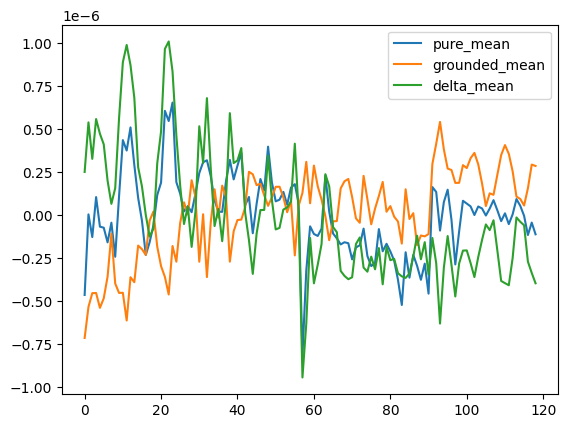

In [9]:
eeg_statistics.iloc[:, :3].plot()

<Axes: >

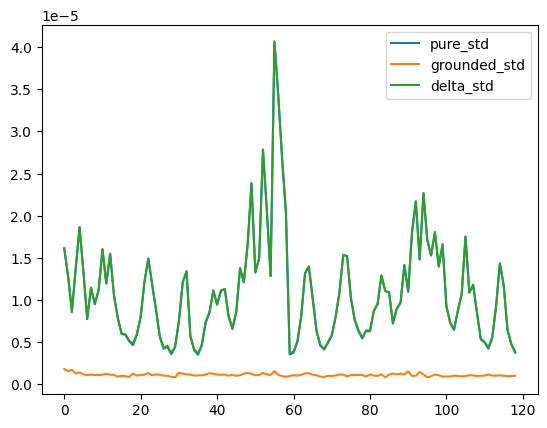

In [10]:
eeg_statistics.iloc[:, 3:].plot()

## pyRiemann

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    precision_recall_fscore_support as score,
    f1_score
)
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

from pyriemann.estimation import XdawnCovariances, BlockCovariances, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM, TSclassifier
from pyriemann.utils.mean import mean_riemann

In [15]:
def classification_report(target, preds):
    acc = np.mean(preds == target)
    balanced_acc = balanced_accuracy_score(target, preds)
    
    precision, recall, f1, support = score(
        target, 
        preds, 
        zero_division=0
    )
    metrics_df = pd.DataFrame({
        'Label': [-1, 0, 1],
        'Precision': [f"{p * 100:.1f}%" for p in precision],
        'Recall': [f"{r * 100:.1f}%" for r in recall],
        'FScore': [f"{f:.3f}" for f in f1],
        'Support': support
    })
    markdown_table = metrics_df.to_markdown(index=False)
    
    print(markdown_table)
    print()
    print(f"Accuracy: {acc:.3f}")
    print(f"Balanced accuracy: {balanced_acc:.3f}")
    print(f"Macro f1-score: {f1_score(target, preds, average='macro'):.3f}")
    print(f"Weighted f1-score: {f1_score(target, preds, average='weighted'):.3f}")
    
    names = ["negative", "neutral", "positive"]
    cm = confusion_matrix(target, preds)
    ConfusionMatrixDisplay(cm, display_labels=names).plot()
    plt.show()

### XdawnCovariances + TangentSpace

**Use eeg channels only**

In [113]:
n_components = 8

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),
    OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000)),
)

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(eeg_signals[train_idx], y_train)
    preds[test_idx] = clf.predict(eeg_signals[test_idx])

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 25.0%       | 9.4%     |    0.136 |        64 |
|       0 | 77.7%       | 89.5%    |    0.832 |       486 |
|       1 | 14.0%       | 8.3%     |    0.104 |        84 |

Accuracy: 0.707
Balanced accuracy: 0.357
Macro f1-score: 0.358
Weighted f1-score: 0.665


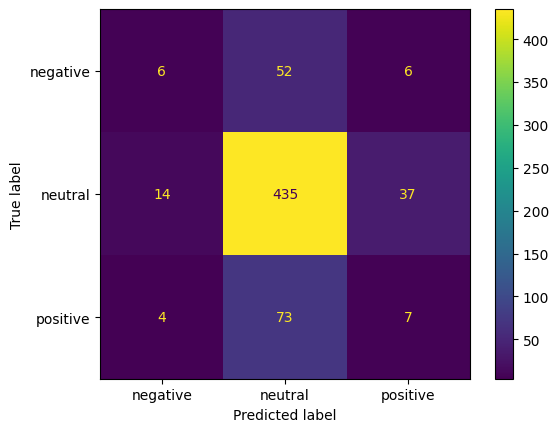

In [114]:
classification_report(target, preds)

**View the output of TangentSpace and XdawnCovariances**

In [75]:
emb_pipeline = make_pipeline(
    XdawnCovariances(n_components), # 48 x 48
    TangentSpace(metric="riemann"), # ???
)

emb_pipeline.fit(eeg_signals, target)
res = emb_pipeline.transform(eeg_signals)
res.shape

(634, 300)

In [77]:
cov_pipeline = make_pipeline(
    XdawnCovariances(10),
)

cov_pipeline.fit(eeg_signals, target)
res = cov_pipeline.transform(eeg_signals)
res.shape

(634, 60, 60)

**Use raw eeg channels**

In [132]:
n_components = 8

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),
    OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000)),
)

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(signals[train_idx, :expected_pairs*2], y_train)
    preds[test_idx] = clf.predict(signals[test_idx, :expected_pairs*2])

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 17.6%       | 4.7%     |    0.074 |        64 |
|       0 | 78.1%       | 93.2%    |    0.85  |       486 |
|       1 | 16.2%       | 7.1%     |    0.099 |        84 |

Accuracy: 0.729
Balanced accuracy: 0.350
Macro f1-score: 0.341
Weighted f1-score: 0.672


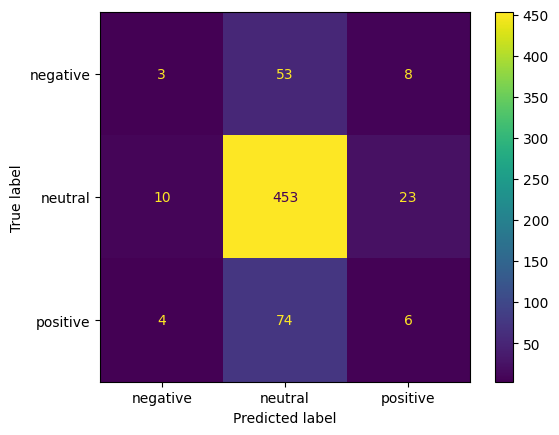

In [133]:
classification_report(target, preds)

**Unite eeg channels and other channels**

In [111]:
n_components = 8

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),
    OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000)),
)

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(total_signals[train_idx], y_train)
    preds[test_idx] = clf.predict(total_signals[test_idx])

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 34.3%       | 18.8%    |    0.242 |        64 |
|       0 | 78.8%       | 90.7%    |    0.843 |       486 |
|       1 | 17.9%       | 8.3%     |    0.114 |        84 |

Accuracy: 0.726
Balanced accuracy: 0.393
Macro f1-score: 0.400
Weighted f1-score: 0.686


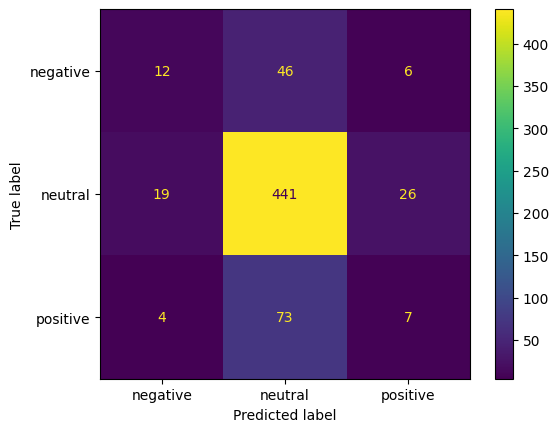

In [112]:
classification_report(target, preds)

**Using raw eeg channels and other channels**

In [130]:
n_components = 8

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),
    OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000)),
)

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(signals[train_idx], y_train)
    preds[test_idx] = clf.predict(signals[test_idx])

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 28.6%       | 9.4%     |    0.141 |        64 |
|       0 | 77.5%       | 92.6%    |    0.843 |       486 |
|       1 | 12.5%       | 4.8%     |    0.069 |        84 |

Accuracy: 0.726
Balanced accuracy: 0.356
Macro f1-score: 0.351
Weighted f1-score: 0.670


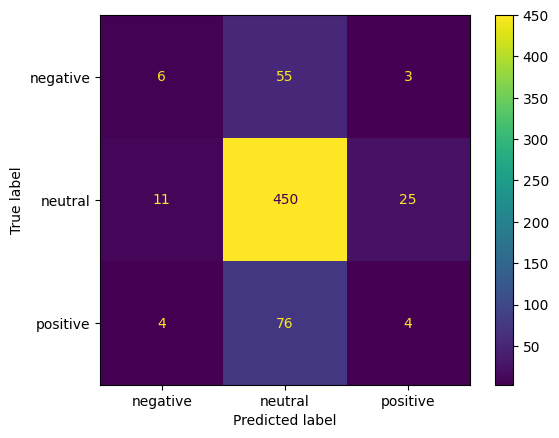

In [131]:
classification_report(target, preds)

#### Results

| BALANCED ACCURACY | EEG   | EEG + other |
|------------------:|-------|-------------|
|   pure & grounded | 0.350 | 0.356       |
|   pure - grounded | 0.357 | 0.393       |

### XdawnCovariances + MDM

In [169]:
n_components = 8
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

clf = make_pipeline(
    XdawnCovariances(n_components),
    MDM(),
)

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(total_signals[train_idx], y_train)
    preds[test_idx] = clf.predict(total_signals[test_idx])

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 27.9%       | 53.1%    |    0.366 |        64 |
|       0 | 83.8%       | 75.7%    |    0.796 |       486 |
|       1 | 12.3%       | 10.7%    |    0.115 |        84 |

Accuracy: 0.648
Balanced accuracy: 0.465
Macro f1-score: 0.425
Weighted f1-score: 0.662


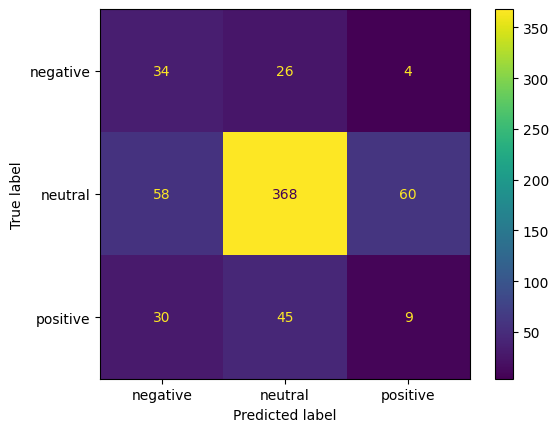

In [170]:
classification_report(target, preds)

### Plot spatial covariances for each class

#### Schema 119-8-15

In [13]:
channel_indices = list(range(123)) + list(range(126, 130)) + list(range(123, 126)) + list(range(130, 142))
reordered_signals = total_signals[:, channel_indices, :]

cov_ext_trials = BlockCovariances(
    estimator="lwf", block_size=[119, 8, 15]
).transform(reordered_signals)

##### Mean data

Plot ALL channels

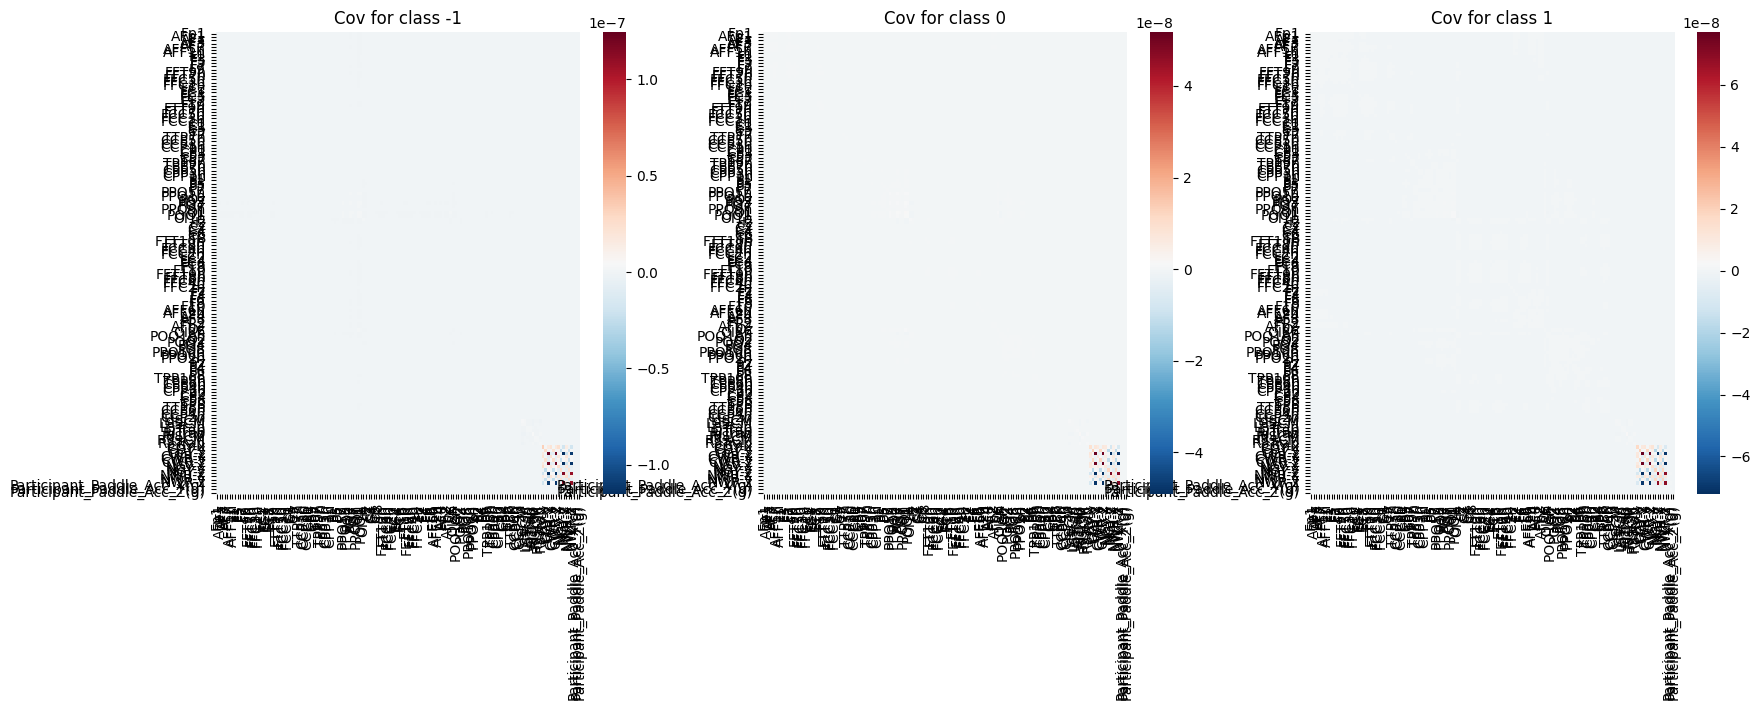

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials[target == label].mean(axis=0),
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices],
        yticklabels=np.array(total_channels)[channel_indices],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

Plot non-EEG channels

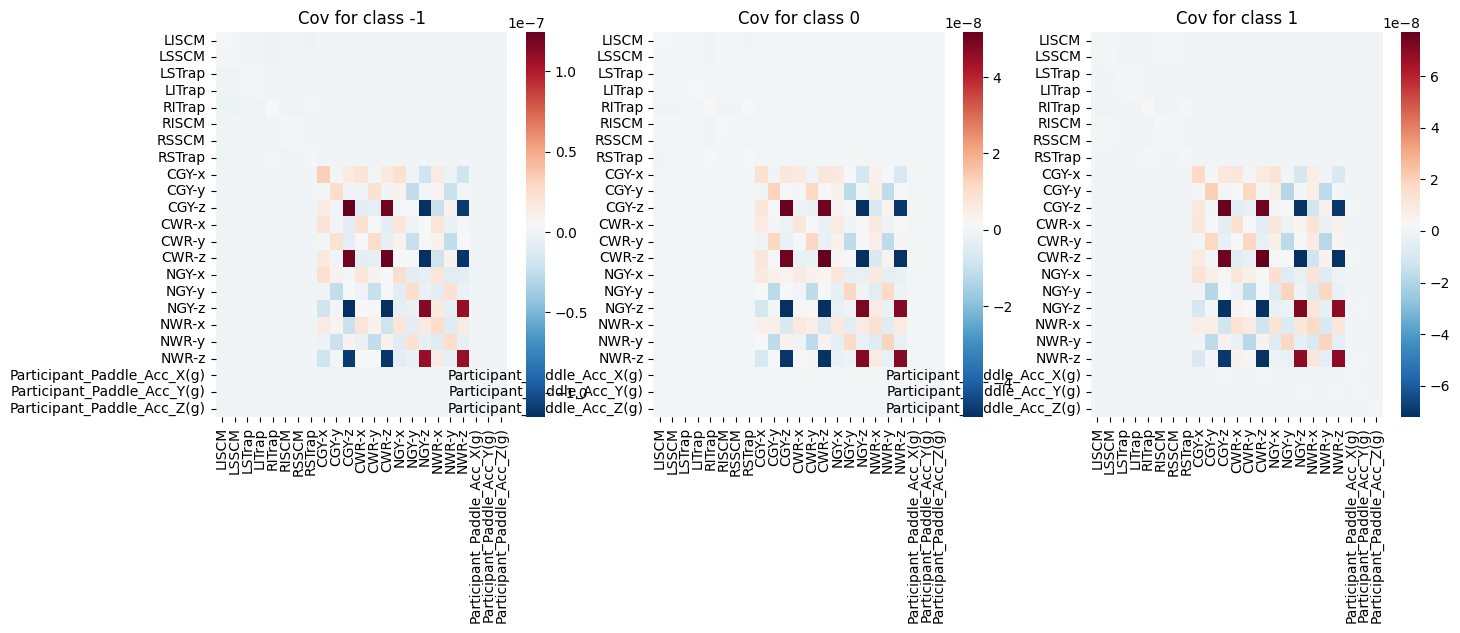

In [209]:
K_CHANNELS = 23
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials[target == label].mean(axis=0)[-K_CHANNELS:, -K_CHANNELS:],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        yticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

##### Mean Riemannian

In [16]:
labels_to_plot = [-1, 0, 1]

# Function to compute mean covariance for a given label
def compute_mean_cov(label):
    selected_covs = cov_ext_trials[target == label]
    return mean_riemann(selected_covs)

# Parallel computation of mean covariances
with concurrent.futures.ProcessPoolExecutor() as executor:
    mean_cov_list = list(executor.map(compute_mean_cov, labels_to_plot))

# Create a dictionary mapping labels to their mean covariances
mean_covariances = dict(zip(labels_to_plot, mean_cov_list))

Plot ALL channels

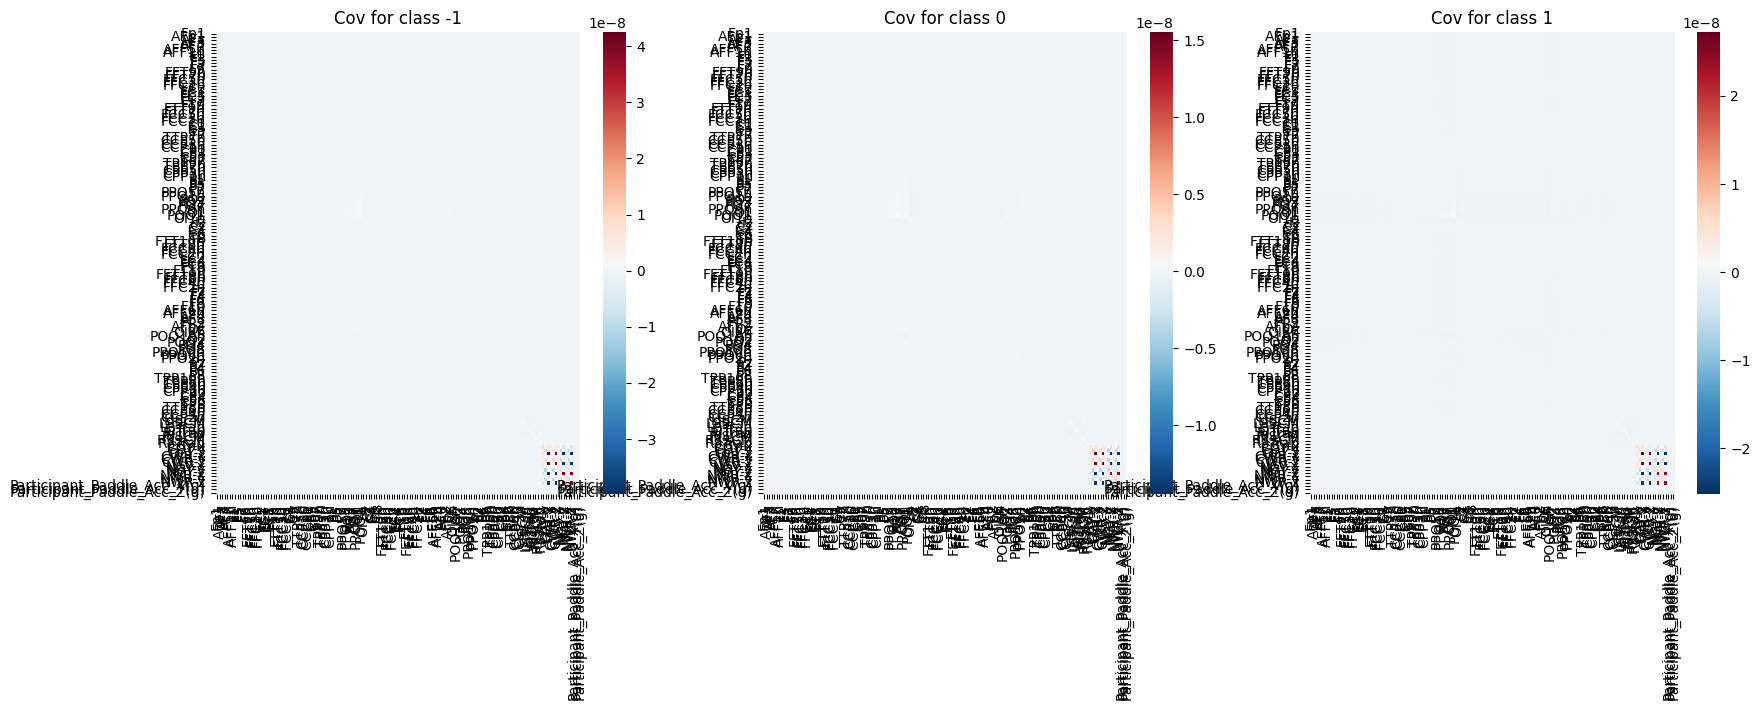

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        mean_covariances[label],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices],
        yticklabels=np.array(total_channels)[channel_indices],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

Plot non-EEG channels

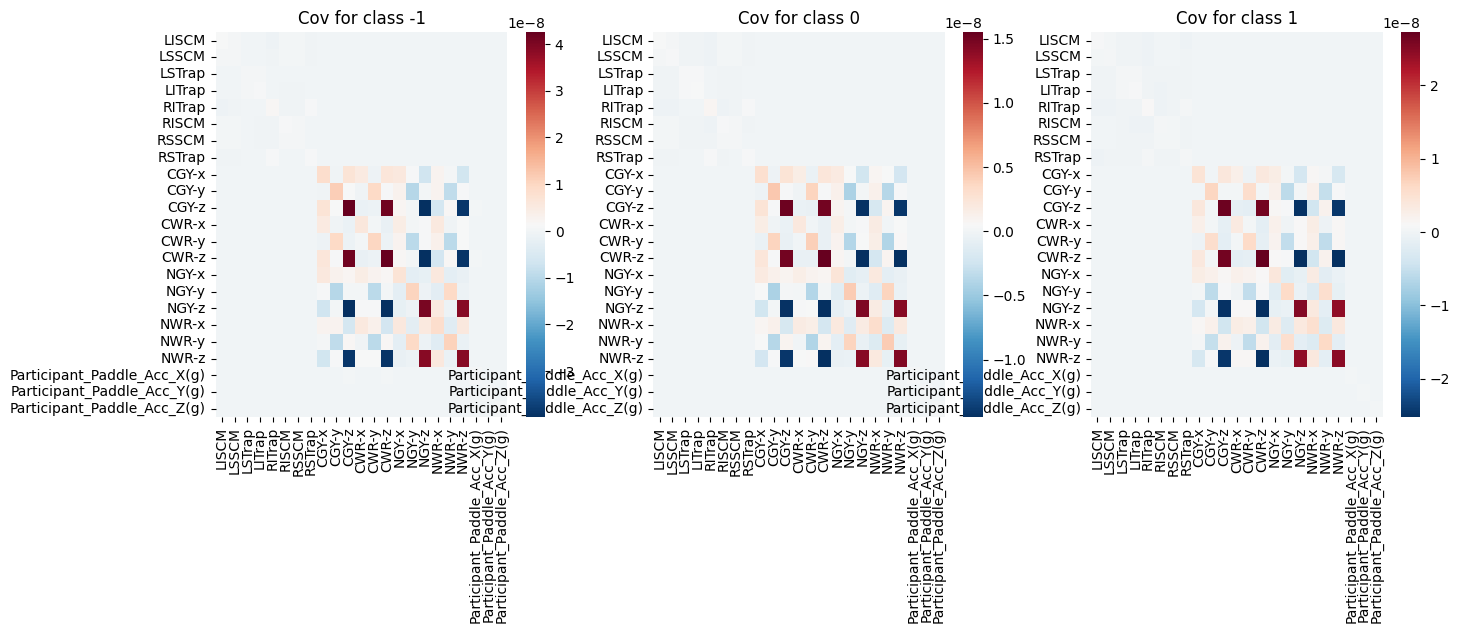

In [18]:
K_CHANNELS = 23
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        mean_covariances[label][-K_CHANNELS:, -K_CHANNELS:],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        yticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

##### Sample data

Plot ALL channels

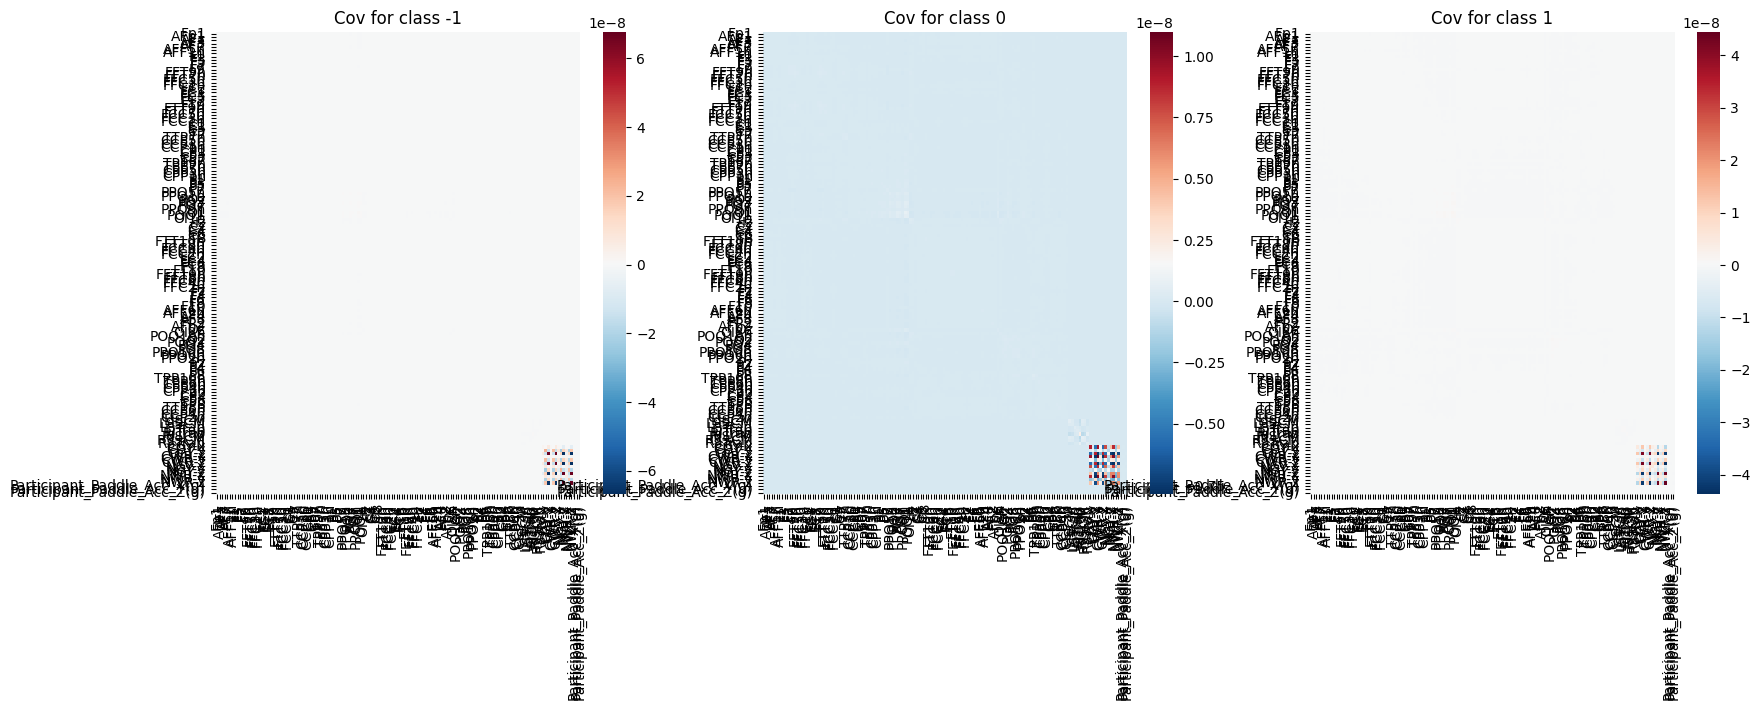

In [212]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
idx = 3

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials[target == label][idx],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices],
        yticklabels=np.array(total_channels)[channel_indices],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

Plot non-EEG channels

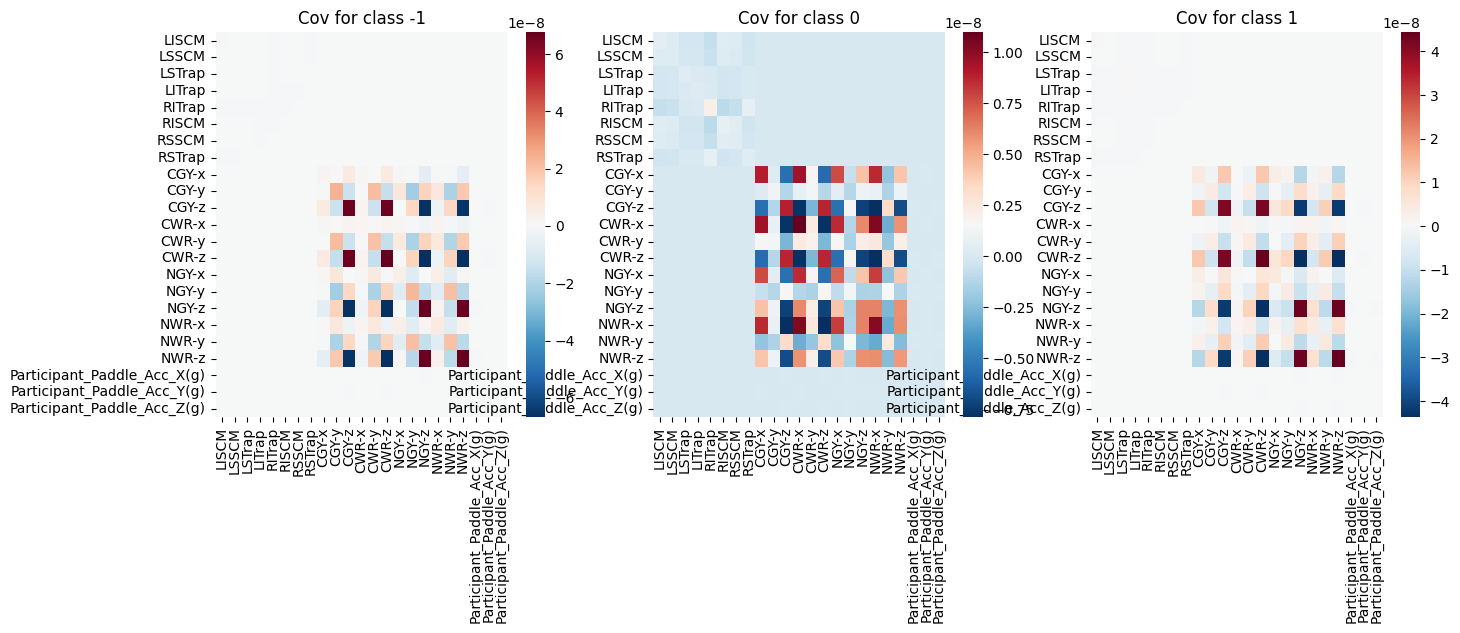

In [211]:
K_CHANNELS = 23
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
idx = 3

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials[target == label][idx, -K_CHANNELS:, -K_CHANNELS:],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        yticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

#### Schema 119-23

Get data

In [213]:
cov_ext_trials_v2 = BlockCovariances(
    estimator="lwf", block_size=[119, 23]
).transform(reordered_signals)

##### Mean data

Plot ALL channels

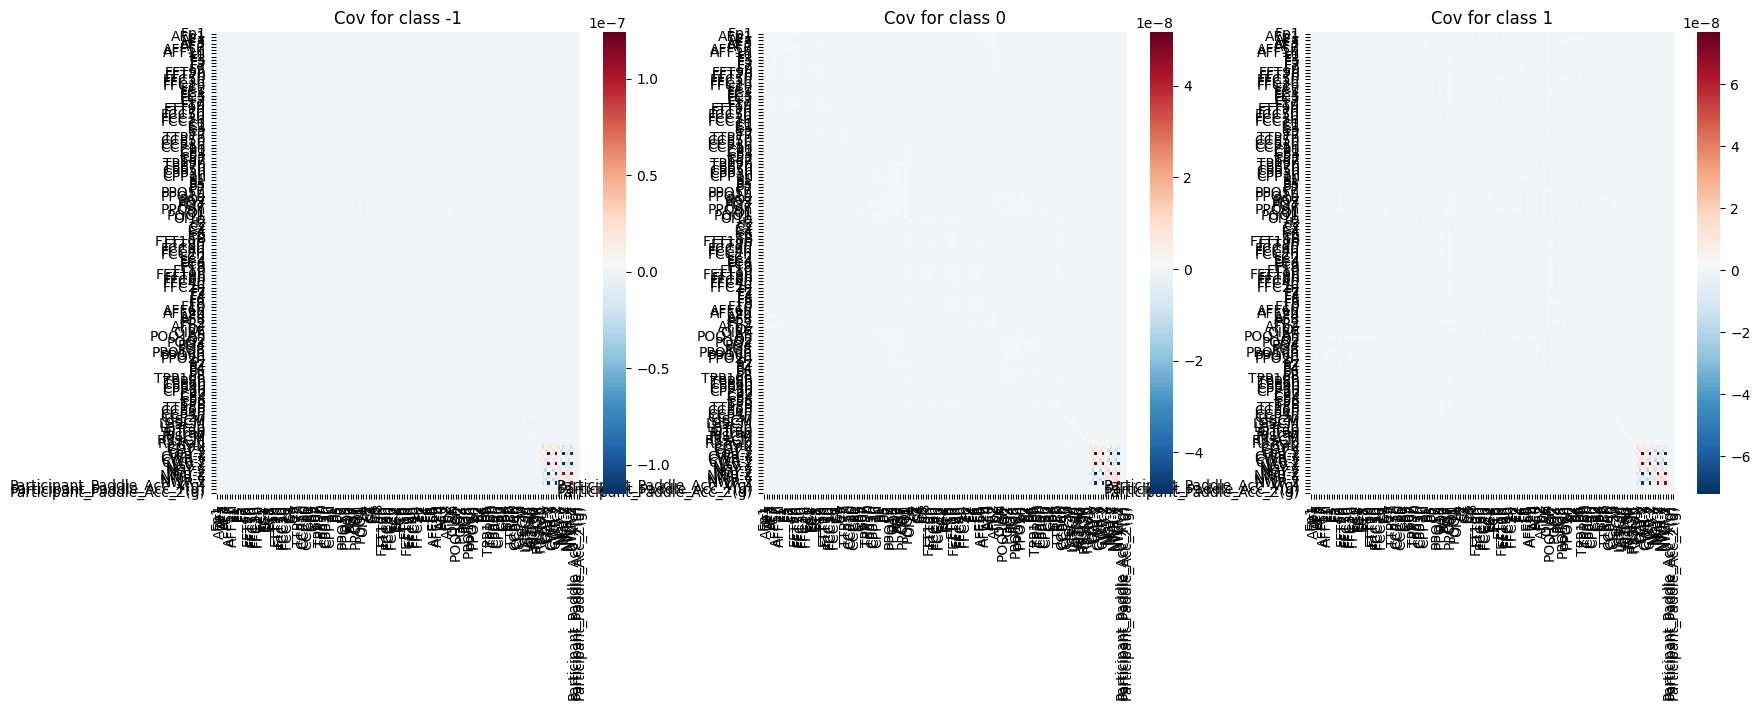

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials_v2[target == label].mean(axis=0),
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices],
        yticklabels=np.array(total_channels)[channel_indices],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

Plot non-EEG channels

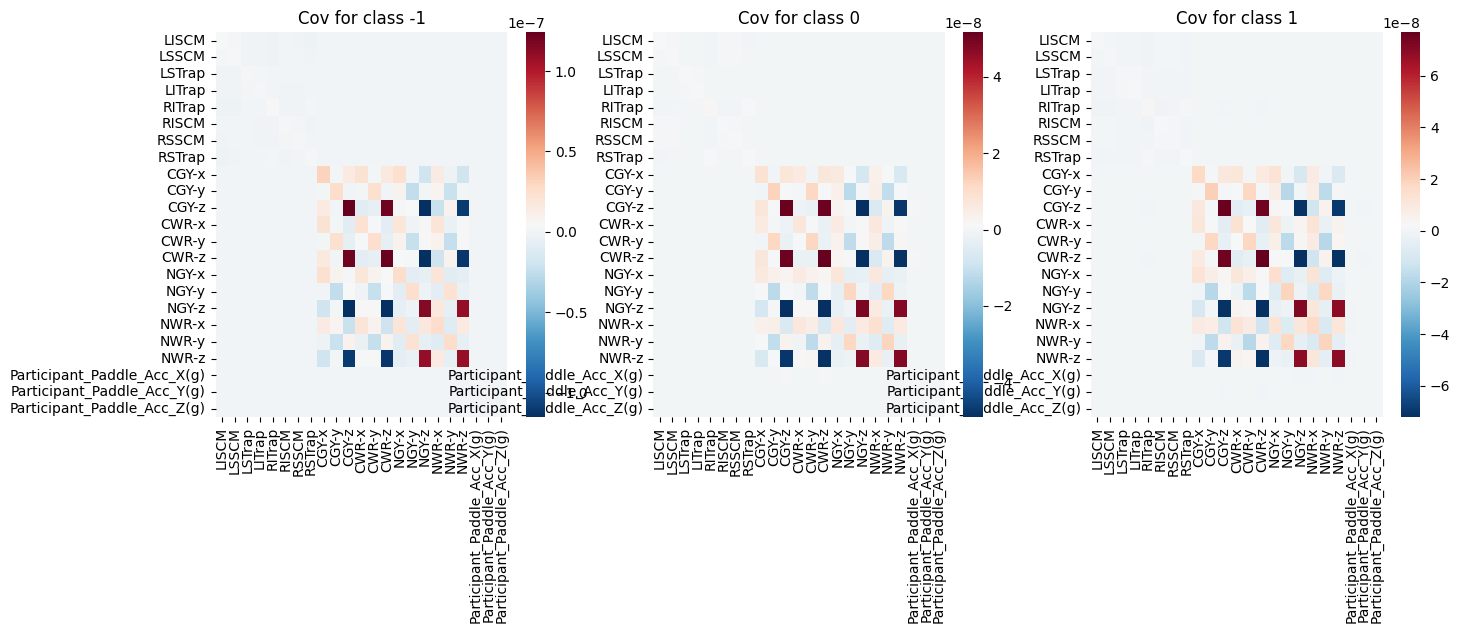

In [215]:
K_CHANNELS = 23
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials_v2[target == label].mean(axis=0)[-K_CHANNELS:, -K_CHANNELS:],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        yticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

##### Sample data

Plot ALL channels

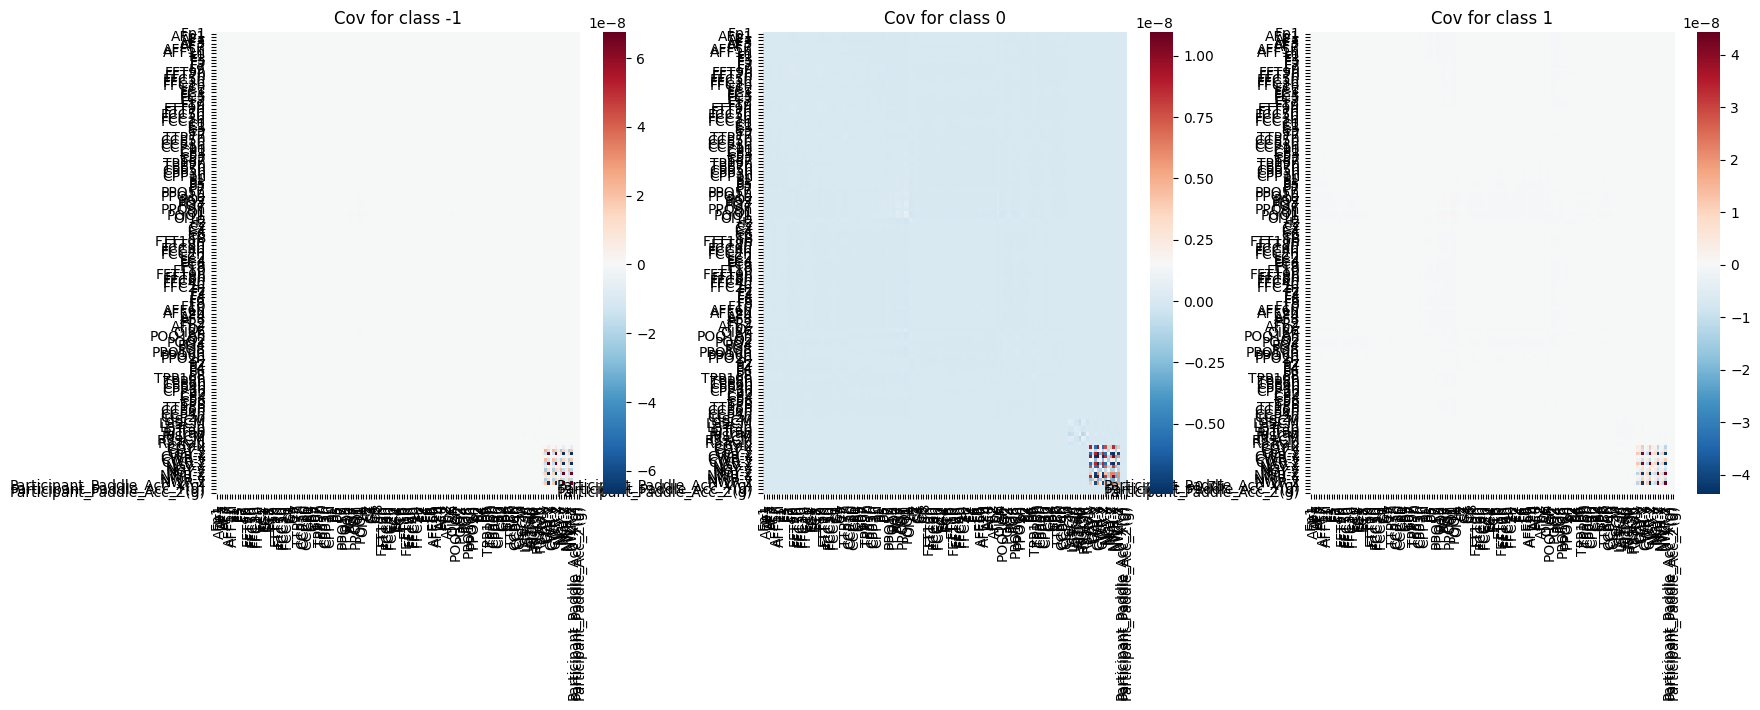

In [216]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
idx = 3

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials_v2[target == label][idx],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices],
        yticklabels=np.array(total_channels)[channel_indices],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

Plot non-EEG channels

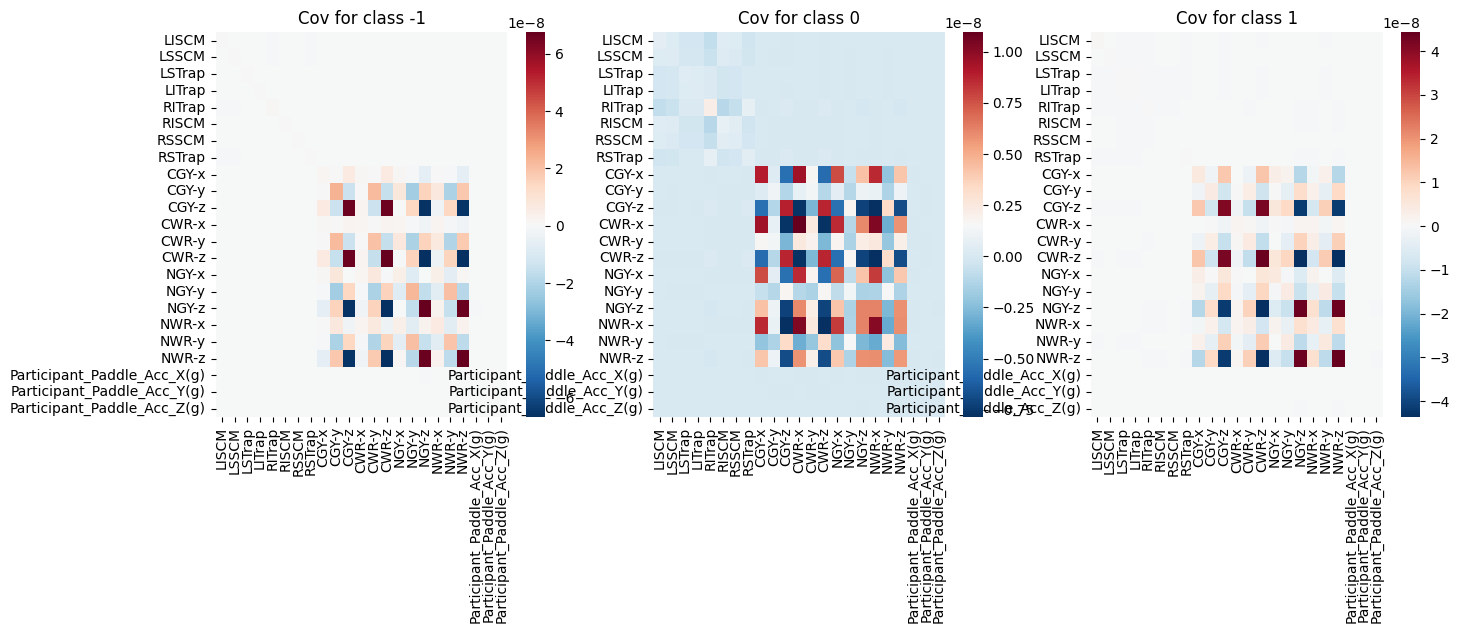

In [217]:
K_CHANNELS = 23
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
idx = 3

for i, label in enumerate([-1, 0, 1]):
    # plt.figure(figsize=(6, 6))
    sns.heatmap(
        cov_ext_trials_v2[target == label][idx, -K_CHANNELS:, -K_CHANNELS:],
        annot=False,
        cmap=plt.get_cmap("RdBu_r"),
        xticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        yticklabels=np.array(total_channels)[channel_indices][-K_CHANNELS:],
        ax=axes[i]
    )
    axes[i].set_title(f"Cov for class {label}")

plt.show()

#### Exploit spatial covariances for prediction

In [19]:
n_components = 8

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
clf = MDM(metric=dict(mean="riemann", distance="riemann"))

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(cov_ext_trials[train_idx], y_train)
    preds[test_idx] = clf.predict(cov_ext_trials[test_idx])

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 26.1%       | 54.7%    |    0.354 |        64 |
|       0 | 85.8%       | 66.9%    |    0.751 |       486 |
|       1 | 12.4%       | 17.9%    |    0.146 |        84 |

Accuracy: 0.591
Balanced accuracy: 0.465
Macro f1-score: 0.417
Weighted f1-score: 0.631


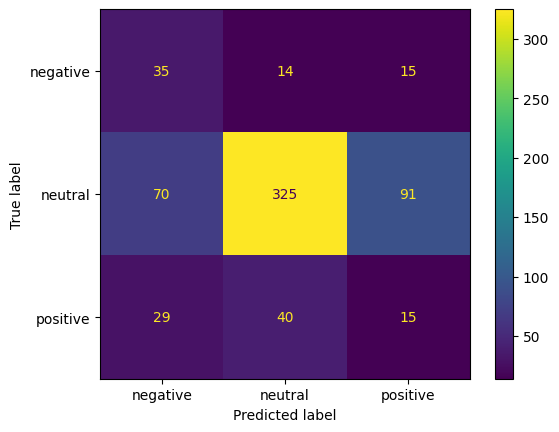

In [20]:
classification_report(target, preds)

## braindecode

Imports

In [7]:
from braindecode.models.util import models_dict
from braindecode.models import EEGConformer
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier

View all available models

In [46]:
print(f'All the Braindecode models:\n{list(models_dict.keys())}')

All the Braindecode models:
['ATCNet', 'Deep4Net', 'DeepSleepNet', 'EEGConformer', 'EEGITNet', 'EEGInception', 'EEGInceptionERP', 'EEGInceptionMI', 'EEGNetv1', 'EEGNetv4', 'EEGResNet', 'HybridNet', 'ShallowFBCSPNet', 'SleepStagerBlanco2020', 'SleepStagerChambon2018', 'SleepStagerEldele2021', 'TCN', 'TIDNet', 'USleep']


Instantiate model

In [83]:
model = EEGConformer(
    n_outputs=3,
    n_chans=142,
    final_fc_length=80,
    return_features=False,
    n_times=125,
    drop_prob=0.2,
    add_log_softmax=False
)
print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 142, 125]             [1, 3]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 142, 125]          [1, 2, 40]                --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 142, 125]          [1, 40, 1, 2]             --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 142, 125]          [1, 40, 142, 101]         1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 142, 101]         [1, 40, 1, 101]           227,240                   [142, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 101]           [1, 40, 1, 101]           80            

/home/vladimiroved/tennis/lib/python3.10/site-packages/braindecode/models/eegconformer.py:134: UserWarning: This model has only been tested on no more than 64 channels. no guarantee to work with more channels.
  warnings.warn("This model has only been tested on no more " +
/home/vladimiroved/tennis/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [81]:
info = mne.create_info(ch_names=total_channels, sfreq=250, ch_types='eeg')
epochs = mne.EpochsArray(total_signals, info=info)
print(epochs)

Not setting metadata
634 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 634 events (all good), 0 – 0.496 s (baseline off), ~86.0 MB, data loaded,
 '1': 634>


In [116]:
model = EEGConformer(
    n_outputs=3,
    n_chans=142,
    n_filters_time=20,
    final_fc_length=40,
    return_features=False,
    n_times=125,
    drop_prob=0.85,
    add_log_softmax=False,
    att_depth=3,
    att_drop_prob=0.85,
    att_heads=5
)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
class_weights = compute_class_weight('balanced', classes=np.unique(target), y=target)
class_weights = torch.tensor(class_weights, dtype=torch.float)

net = EEGClassifier(
    module=model.to(device),
    criterion=nn.CrossEntropyLoss(class_weights),
    train_split=ValidSplit(0.3),
    iterator_train__drop_last=False,
    optimizer=torch.optim.Adam,
    optimizer__lr=5e-4,
    device=device,
    batch_size=32,
    callbacks=[
        "balanced_accuracy",
    ],
)

/home/vladimiroved/tennis/lib/python3.10/site-packages/braindecode/models/eegconformer.py:134: UserWarning: This model has only been tested on no more than 64 channels. no guarantee to work with more channels.
  warnings.warn("This model has only been tested on no more " +


In [117]:
net.fit(epochs, target + 1, epochs=500)

  epoch    train_balanced_accuracy    train_loss    valid_acc    valid_balanced_accuracy    valid_loss     dur
-------  -------------------------  ------------  -----------  -------------------------  ------------  ------
      1                     0.3629        1.2447       0.6283                     0.3806        1.0991  0.5684
      2                     0.3587        1.2973       0.7435                     0.3135        1.1034  0.6219
      3                     0.3385        1.1650       0.7906                     0.3333        1.1046  0.5915
      4                     0.3333        1.2530       0.7853                     0.3311        1.1041  0.5191
      5                     0.3385        1.1705       0.7906                     0.3478        1.1020  0.5985
      6                     0.3444        1.1953       0.7644                     0.3512        1.1080  0.5414
      7                     0.3596        1.1928       0.6545                     0.3193        1.1100  0.5980
 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  EEGConformer (EEGConformer)                                  [1, 142, 125]             [1, 3]                    --                        --
  ├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 142, 125]          [1, 2, 20]                --                        --
  │    └─Sequential (shallownet): 2-1                          [1, 1, 142, 125]          [1, 20, 1, 2]             --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 1, 142, 125]          [1, 20, 142, 101]         520                       [1, 25]
  │    │    └─Conv2d (1): 3-2    

Model's evaluation

In [118]:
# outp = net.module_.forward(torch.tensor(epochs[200].get_data(), dtype=torch.float).to(device))
# torch.round(outp.detach(), decimals=3)

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 18.9%       | 84.4%    |    0.309 |        64 |
|       0 | 84.7%       | 60.3%    |    0.704 |       486 |
|       1 | 33.3%       | 1.2%     |    0.023 |        84 |

Accuracy: 0.549
Balanced accuracy: 0.486
Macro f1-score: 0.346
Weighted f1-score: 0.574


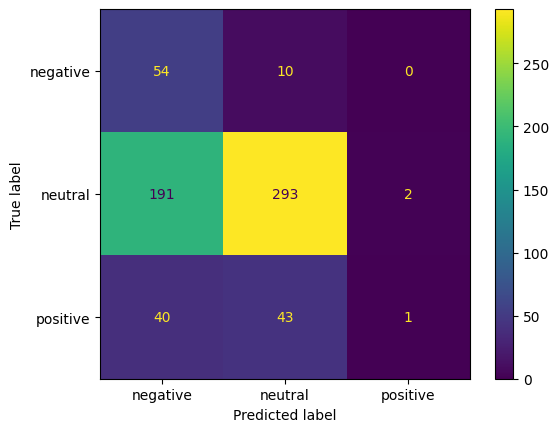

In [119]:
preds = net.predict(epochs)
classification_report(target, preds - 1)

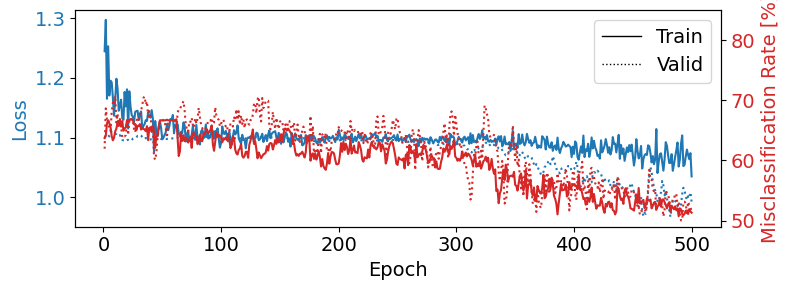

In [120]:
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_balanced_accuracy', 'valid_balanced_accuracy']
df = pd.DataFrame(net.history[:, results_columns], columns=results_columns,
                  index=net.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], color='tab:blue', legend=False,
    fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

## pyRiemann time-varying

Define class `WindowedCovarianceTransformer` for calculating covariance matrices per each window

In [34]:
WINDOW_SIZE = 50
WINDOW_STEP = 25


def rolling_window(a, window, step=1):
    n_channels, n_times = a.shape
    K_WINDOWS = (n_times - window) // step + 1
    shape = (K_WINDOWS, n_channels, window)
    strides = (a.strides[1]*step, a.strides[0], a.strides[1])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


class WindowedCovarianceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=WINDOW_SIZE, step=WINDOW_STEP, cov_estimator=None, n_jobs=4):
        self.window_size = window_size
        self.step = step
        self.cov_estimator = cov_estimator if cov_estimator else Covariances()
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_channels, n_times = X.shape
        window_size = self.window_size
        step = self.step
        K_WINDOWS = (n_times - window_size) // step + 1

        def compute_covariances(sample):
            windows = rolling_window(sample, window_size, step)  # Shape: (K_WINDOWS, n_channels, window_size)
            covs = self.cov_estimator.transform(windows)  # Shape: (K_WINDOWS, n_channels, n_channels)
            return covs

        # Parallel computation
        covariances = Parallel(n_jobs=self.n_jobs)(
            delayed(compute_covariances)(X[i]) for i in range(n_samples)
        )

        return np.array(covariances)

Define `AggregateCovariances`

In [51]:
class AggregateCovariances(BaseEstimator, TransformerMixin):
    def __init__(self, method='mean', regularization=1e-6, n_jobs=4):
        self.method = method
        self.regularization = regularization
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.method == 'mean':
            mean = X.mean(axis=1)
            reg = np.expand_dims(np.eye(X.shape[2]), axis=0) * self.regularization
            return mean + reg
        elif self.method == 'riemannian':
            mean = Parallel(n_jobs=self.n_jobs)(
                delayed(mean_riemann)(X[i]) for i in range(X.shape[0])
            )
            reg = np.expand_dims(np.eye(X.shape[2]), axis=0) * self.regularization
            return mean + reg
        else:
            raise ValueError(f"Unsupported aggregation method: {self.method}")

Define modified pipeline

0it [00:00, ?it/s]

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 22.5%       | 50.0%    |    0.311 |        64 |
|       0 | 83.0%       | 76.5%    |    0.797 |       486 |
|       1 | 13.6%       | 7.1%     |    0.094 |        84 |

Accuracy: 0.647
Balanced accuracy: 0.446
Macro f1-score: 0.400
Weighted f1-score: 0.654


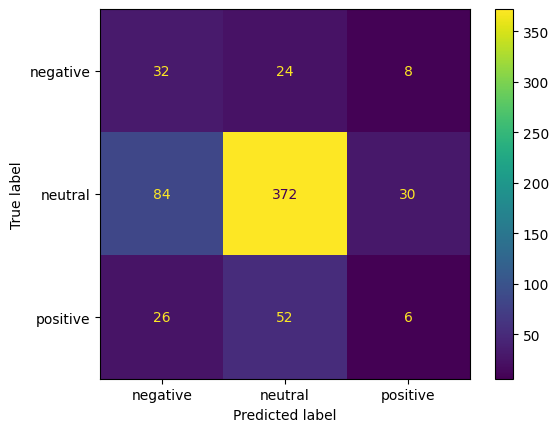

In [62]:
windowed_cov_transformer = WindowedCovarianceTransformer(
    cov_estimator=Covariances(estimator='oas')
)
agg_cov_transformer = AggregateCovariances(method='mean')

clf = Pipeline([
    ('windowed_cov', windowed_cov_transformer),
    ('agg_cov', agg_cov_transformer),
    ('ts', TangentSpace(metric="riemann")),
    ('clf', OneVsRestClassifier(
        LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            penalty='l1',
            solver='liblinear'
        )
    )),
])

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
preds = np.zeros(len(target))

for train_idx, test_idx in tqdm(cv.split(target)):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(total_signals[train_idx], y_train)
    preds[test_idx] = clf.predict(total_signals[test_idx])
    
    
classification_report(target, preds)

0it [00:00, ?it/s]

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 0.0%        | 0.0%     |    0     |        64 |
|       0 | 76.7%       | 100.0%   |    0.868 |       486 |
|       1 | 0.0%        | 0.0%     |    0     |        84 |

Accuracy: 0.767
Balanced accuracy: 0.333
Macro f1-score: 0.289
Weighted f1-score: 0.665


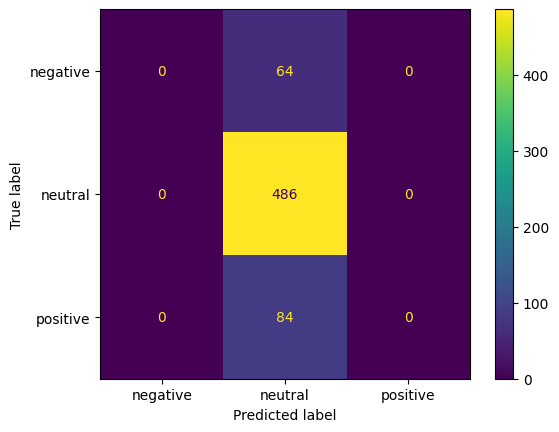

In [61]:
windowed_cov_transformer = WindowedCovarianceTransformer(
    cov_estimator=Covariances(estimator='oas')
)
agg_cov_transformer = AggregateCovariances(method='mean')

clf_2 = Pipeline([
    ('windowed_cov', windowed_cov_transformer),
    ('agg_cov', agg_cov_transformer),
    ('mdm', MDM(n_jobs=4)),
])

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
preds_2 = np.zeros(len(target))

for train_idx, test_idx in tqdm(cv.split(target)):
    y_train, y_test = target[train_idx], target[test_idx]

    clf_2.fit(total_signals[train_idx], y_train)
    preds_2[test_idx] = clf.predict(total_signals[test_idx])
    
    
classification_report(target, preds_2)

## SSA

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pymssa import MSSA


n_samples, n_features, n_timestamps = total_signals.shape
X_train, X_test, y_train, y_test = train_test_split(total_signals, target, test_size=0.2, random_state=SEED)

X_train_flat = pd.DataFrame(
    np.hstack([X_train[:, i, :].T for i in range(n_features)]),
    columns=[f"feature_{i}_t{t}" for i in range(n_features) for t in range(n_timestamps)]
)
X_test_flat = pd.DataFrame(
    np.hstack([X_test[:, i, :].T for i in range(n_features)]),
    columns=[f"feature_{i}_t{t}" for i in range(n_features) for t in range(n_timestamps)]
)

window_size = 20
n_components = 5

mssa = MSSA(window_size=window_size, n_components=n_components)
mssa.fit(X_train_flat)

X_train_components = mssa.components_
X_test_components = mssa.transform(X_test_flat)

def extract_features(components):
    return np.hstack([np.mean(components, axis=1), np.var(components, axis=1)])

X_train_features = extract_features(X_train_components)
X_test_features = extract_features(X_test_components)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_features, y_train)

y_pred = clf.predict(X_test_features)
print("Classification Report:\n", classification_report(y_test, y_pred))

/home/vladimiroved/tennis/lib/python3.10/site-packages/pymssa/mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

{np.int64(1)}

## Raw code

|   Label | Precision   | Recall   |   FScore |   Support |
|--------:|:------------|:---------|---------:|----------:|
|      -1 | 4.8%        | 1.6%     |    0.024 |        64 |
|       0 | 76.8%       | 90.5%    |    0.831 |       486 |
|       1 | 12.5%       | 6.0%     |    0.081 |        84 |

Accuracy: 0.703
Balanced accuracy: 0.327
Macro f1-score: 0.312
Weighted f1-score: 0.650


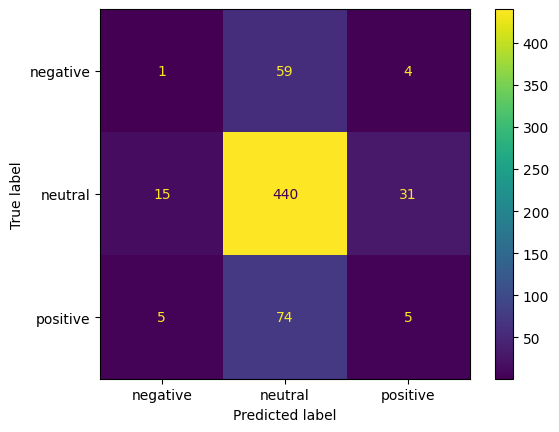

In [26]:
final_sample_2 = np.load(f'signals_01.npz', allow_pickle=True)

signals = final_sample_2['signals']
channels = final_sample_2['channels']

num_signals = signals.shape[0]
expected_pairs = 119

eeg_signals = signals[:, :expected_pairs] - signals[:, expected_pairs:2 * expected_pairs]
other_signals = signals[:, 2*expected_pairs:]
total_signals = np.concat((eeg_signals, other_signals), axis=1)

eeg_channels = channels[:expected_pairs]
total_channels = channels[:expected_pairs].tolist() + channels[2 * expected_pairs:].tolist()

other_signals = signals[:, 2*expected_pairs:]
target = final_sample_2['target'].astype(int)
target[target == 2] = 1
gc.collect()


n_components = 8

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),
    OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000)),
)

preds = np.zeros(len(target))

for train_idx, test_idx in cv.split(target):
    y_train, y_test = target[train_idx], target[test_idx]

    clf.fit(total_signals[train_idx], y_train)
    preds[test_idx] = clf.predict(total_signals[test_idx])
    
classification_report(target, preds)

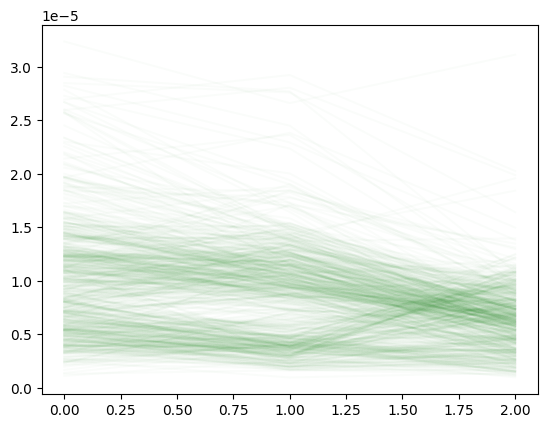

In [144]:
for i in range(signals.shape[0]):
    plt.plot(np.sqrt(np.sum(np.square(signals[i, -3:]), axis=1)), color='green', alpha=0.02);